In [ ]:
!pip3 install backtrader[plotting]
!pip3 install pyfolio


     |████████████████████████████████| 410 kB 5.6 MB/s 
     |████████████████████████████████| 91 kB 4.4 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2-py3-none-any.whl size=88681 sha256=02f5ebd3d8e94a8f07b0ed698657edc812bb3d40ad444fad273c26d624513d03
  Stored in directory: /root/.cache/pip/wheels/e4/96/9b/0dfff5453e702fd780a099b7c850521099c5ec0dfafae189f9
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39777 sha256=2ddb432be359960c951d50ac08cfb16cdf89248513e33d353914a20278c4570c
  Stored in directory: /root/.cache/pip/wheels/d9/91/4b/654fcff57477efcf149eaca236da2fce991526cbab431bf312
Successfully built pyfolio empyrical


In [ ]:
import matplotlib as plt
from datetime import datetime
import backtrader as bt
import pandas as pd
import numpy as np
import math 
import statistics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.stats as st
import datetime as dt
import pyfolio as pf

from scipy.optimize import minimize

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import pickle
import dill
import weakref
import pyfolio
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


Mounted at /content/drive


In [ ]:
TIME_STEPS = 24 # How far in the past you want to use past data as features
TARGET_TIME_STEPS = 12 # How far in the future you want to make predictions
#INP_COLS = [0, 1, 2, 3, 4]
INP_COLS = [1]
OUT_COL = 1

def build_timeseries(mat, input_cols, output_col, time_steps, target_time_steps):
    # input_cols is a list of columns that would act as input columns
    # output_col is the column that would act as output column
    # total number of time-series samples = len(mat) - time_steps - target_time_steps + 1
    dim_0 = mat.shape[0] - time_steps - target_time_steps + 1
    dim_1 = len(input_cols)
    
    x = np.zeros((dim_0, time_steps))
    y = np.zeros((dim_0,))
    
    for i in range(dim_0):  
        x[i] = mat[i: time_steps + i]
        y[i] = mat[time_steps + target_time_steps + i - 1]

    return x, y

def convert_price(pred, sc, feature_num, out_col):
# Return predicted price for given input
    #pred_reverted = np.zeros(shape=(pred.shape[0], 1))
    #pred_reverted[:, 0] = pred
    pred_reverted = sc.inverse_transform(pred.reshape(-1, 1))
    predicted_price = pred_reverted[:]
    return predicted_price

In [ ]:
# Expected growth function

def growth_function(f, p, q, risk_free, mu, sigma):
  return -1 * (p * (math.log(1 + risk_free + f * (mu - risk_free + sigma) )) + q * (math.log(1 + risk_free + f * (mu - risk_free - sigma))) )

def optimal_f(p, q, risk_free, mu, sigma):
  #cons = ({'type': 'eq', 'fun': lambda x: 1 - sum(x)}) 
  bnds = [(0,4)]
  f = 0.5
  res = minimize(growth_function, x0 = f, args = (p, q, risk_free, mu, sigma), method = 'SLSQP', bounds = bnds, tol = 1e-30)
  return res

#LSTM Kelly with custom probability

In [ ]:
class lstm_Strategy(bt.Strategy):
    params = dict(log_period = 1)

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.datetime(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None
    def start(self):
        self.order = None 

    def __init__(self):
        self.data_close = self.datas[0].close
        self.log_return_list = []
        self.init_price = 0 
        self.current_f = 0
        self.model = None
        self.predicted_price_val = None
        self.real_price_val = None
        self.sc = None
        self.predicted_price = 0

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('')
        
        
        real_price = self.datas[0].close.get(size=1)
        predicted_price = prediction_data.iloc[len(self) - 1]['Predicted']
        diff = np.abs(predicted_price - real_price)
        #print(diff)
        z_score = diff / prediction_data.iloc[len(self) - 1]['Predicted_std']
        #print(z_score)
        probs = st.norm.cdf(z_score)

        f_data = pd.Series(list(self.datas[0].close.get(size=30)))
        current_log = np.log(f_data/ f_data.shift(1))
        current_mu = (np.mean(current_log) )
        current_sigma = (np.std(current_log) )
        if (predicted_price - real_price[0]) > 0 :
          current_f = optimal_f(probs[0], 1 - probs[0], 0, current_mu, current_sigma) 
          print('Current f', current_f.x[0])
          self.order = self.order_target_percent(target = 0.25 * current_f.x[0])
        else  :
          current_f = optimal_f(1 - probs[0], probs[0], 0, current_mu, current_sigma) 
          print('Current f', current_f.x[0])
          self.order = self.order_target_percent(target = 0.25 * current_f.x[0])

          

#Phase 1


## Cryptocurrencies


### USD - BTC

In [ ]:
btc_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/BTC-USD.csv', index_col=0, parse_dates=True)
btc_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/BTC-USD_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(btc_data) - len(prediction_data)
train_len

1274

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=btc_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data, name='data')

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2019-11-24T00:00:00, 
Current f 0.5
2019-11-25T00:00:00, BUY EXECUTED, Price: 7047.92, Cost: 119814.59, Comm 0.00
2019-11-25T00:00:00, 
Current f 0.5
2019-11-26T00:00:00, 
Current f 0.5
2019-11-27T00:00:00, 
Current f 0.5
2019-11-28T00:00:00, 
Current f 0.5
2019-11-29T00:00:00, 
Current f 0.5
2019-11-30T00:00:00, 
Current f 0.5
2019-12-01T00:00:00, 
Current f 0.5
2019-12-02T00:00:00, 
Current f 0.5
2019-12-03T00:00:00, 
Current f 0.5
2019-12-04T00:00:00, 
Current f 0.5
2019-12-05T00:00:00, 
Current f 0.5
2019-12-06T00:00:00, 
Current f 0.5
2019-12-07T00:00:00, 
Current f 0.5
2019-12-08T00:00:00, 
Current f 0.5
2019-12-09T00:00:00, 
Current f 0.5
2019-12-10T00:00:00, 
Current f 0.5
2019-12-11T00:00:00, 
Current f 0.5
2019-12-12T00:00:00, 
Current f 0.5
2019-12-13T00:00:00, 
Current f 0.5
2019-12-14T00:00:00, 
Current f 0.5
2019-12-15T00:00:00, 
Current f 0.5
2019-12-16T00:00:00, 
Current f 0.5
2019-12-17T00:00:00, 
Current f 0.5
2019-12-18T00:00:00, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Current f 4.0
2019-12-24T00:00:00, BUY EXECUTED, Price: 7355.63, Cost: 875319.78, Comm 0.00
2019-12-24T00:00:00, 
Current f 4.0
2019-12-25T00:00:00, 
Current f 4.0
2019-12-26T00:00:00, 
Current f 4.0
2019-12-27T00:00:00, 
Current f 3.9656632841842967
2019-12-28T00:00:00, 
Current f 2.4819878651852147
2019-12-29T00:00:00, SELL EXECUTED, Price: 7317.99, Cost: 373031.10, Comm 0.00
2019-12-29T00:00:00, 
Current f 1.2755329098997483
2019-12-30T00:00:00, SELL EXECUTED, Price: 7422.65, Cost: 299887.75, Comm 0.00
2019-12-30T00:00:00, 
Current f 4.0
2019-12-31T00:00:00, BUY EXECUTED, Price: 7293.00, Cost: 678248.55, Comm 0.00
2019-12-31T00:00:00, 
Current f 4.0
2020-01-01T00:00:00, 
Current f 3.999999999999999
2020-01-02T00:00:00, 
Current f 4.0
2020-01-03T00:00:00, 
Current f 4.0
2020-01-04T00:00:00, 
Current f 4.0
2020-01-05T00:00:00, 
Current f 4.0
2020-01-06T00:00:00, 
Current f 1.151915073605706
2020-01-07T00:00:00, SELL EXECUTED, Price: 7769.22, Cost: 708085.34, Comm 0.00
2020-01-07T00:00

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2019-11-25',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


In [ ]:
btc_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/BTC-USD.csv', index_col=0, parse_dates=True)
btc_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/BTC-USD_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(btc_data) - len(prediction_data)
train_len


1274

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=btc_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2019-11-24T00:00:00, 
Current f 0.5
2019-11-25T00:00:00, BUY EXECUTED, Price: 7047.92, Cost: 119814.59, Comm 0.00
2019-11-25T00:00:00, 
Current f 0.5
2019-11-26T00:00:00, 
Current f 0.5
2019-11-27T00:00:00, 
Current f 0.5
2019-11-28T00:00:00, 
Current f 0.5
2019-11-29T00:00:00, 
Current f 0.5
2019-11-30T00:00:00, 
Current f 0.5
2019-12-01T00:00:00, 
Current f 0.5
2019-12-02T00:00:00, 
Current f 0.5
2019-12-03T00:00:00, 
Current f 0.5
2019-12-04T00:00:00, 
Current f 0.5
2019-12-05T00:00:00, 
Current f 0.5
2019-12-06T00:00:00, 
Current f 0.5
2019-12-07T00:00:00, 
Current f 0.5
2019-12-08T00:00:00, 
Current f 0.5
2019-12-09T00:00:00, 
Current f 0.5
2019-12-10T00:00:00, 
Current f 0.5
2019-12-11T00:00:00, 
Current f 0.5
2019-12-12T00:00:00, 
Current f 0.5
2019-12-13T00:00:00, 
Current f 0.5
2019-12-14T00:00:00, 
Current f 0.5
2019-12-15T00:00:00, 
Current f 0.5
2019-12-16T00:00:00, 
Current f 0.5
2019-12-17T00:00:00, 
Current f 0.5
2019-12-18T00:00:00, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Current f 1.2755329098997483
2019-12-30T00:00:00, SELL EXECUTED, Price: 7422.65, Cost: 299887.75, Comm 0.00
2019-12-30T00:00:00, 
Current f 4.0
2019-12-31T00:00:00, BUY EXECUTED, Price: 7293.00, Cost: 678248.55, Comm 0.00
2019-12-31T00:00:00, 
Current f 4.0
2020-01-01T00:00:00, 
Current f 3.999999999999999
2020-01-02T00:00:00, 
Current f 4.0
2020-01-03T00:00:00, 
Current f 4.0
2020-01-04T00:00:00, 
Current f 4.0
2020-01-05T00:00:00, 
Current f 4.0
2020-01-06T00:00:00, 
Current f 1.151915073605706
2020-01-07T00:00:00, SELL EXECUTED, Price: 7769.22, Cost: 708085.34, Comm 0.00
2020-01-07T00:00:00, 
Current f 1.109138822452671e-16
2020-01-08T00:00:00, SELL EXECUTED, Price: 8163.69, Cost: 284694.11, Comm 0.00
2020-01-08T00:00:00, 
Current f 0.0
2020-01-09T00:00:00, SELL EXECUTED, Price: 8079.86, Cost: 7299.85, Comm 0.00
2020-01-09T00:00:00, 
Current f 3.1638472542074254
2020-01-10T00:00:00, BUY EXECUTED, Price: 7879.07, Cost: 850939.70, Comm 0.00
2020-01-10T00:00:00, 
Current f 2.2182776449

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2019-11-25',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### USD - ETH

In [ ]:
eth_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/ETH-USD.csv', index_col=0, parse_dates=True)
eth_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/ETH-USD_Predicted.csv', index_col=0, parse_dates=True)
train_len = len(eth_data) - len(prediction_data)
train_len

1274

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=eth_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2019-11-24T00:00:00, 
Current f 0.5
2019-11-25T00:00:00, BUY EXECUTED, Price: 142.83, Cost: 124980.36, Comm 0.00
2019-11-25T00:00:00, 
Current f 0.5
2019-11-26T00:00:00, SELL EXECUTED, Price: 146.48, Cost: 2571.02, Comm 0.00
2019-11-26T00:00:00, 
Current f 0.5
2019-11-27T00:00:00, SELL EXECUTED, Price: 148.97, Cost: 1856.85, Comm 0.00
2019-11-27T00:00:00, 
Current f 0.5
2019-11-28T00:00:00, SELL EXECUTED, Price: 153.01, Cost: 2713.86, Comm 0.00
2019-11-28T00:00:00, 
Current f 0.5
2019-11-29T00:00:00, BUY EXECUTED, Price: 151.72, Cost: 758.59, Comm 0.00
2019-11-29T00:00:00, 
Current f 0.5
2019-11-30T00:00:00, SELL EXECUTED, Price: 155.30, Cost: 2286.21, Comm 0.00
2019-11-30T00:00:00, 
Current f 0.5
2019-12-01T00:00:00, BUY EXECUTED, Price: 152.54, Cost: 1830.48, Comm 0.00
2019-12-01T00:00:00, 
Current f 0.5
2019-12-02T00:00:00, BUY EXECUTED, Price: 151.19, Cost: 907.11, Comm 0.00
2019-12-02T00:00:00, 
Current f 0.5
2019-12-03T00:00:00, BUY EXECUTED, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Current f 0.5
2019-12-08T00:00:00, BUY EXECUTED, Price: 148.77, Cost: 148.77, Comm 0.00
2019-12-08T00:00:00, 
Current f 0.5
2019-12-09T00:00:00, SELL EXECUTED, Price: 151.26, Cost: 1575.47, Comm 0.00
2019-12-09T00:00:00, 
Current f 0.5
2019-12-10T00:00:00, BUY EXECUTED, Price: 148.23, Cost: 2075.15, Comm 0.00
2019-12-10T00:00:00, 
Current f 0.5
2019-12-11T00:00:00, BUY EXECUTED, Price: 146.27, Cost: 1462.67, Comm 0.00
2019-12-11T00:00:00, 
Current f 0.5
2019-12-12T00:00:00, BUY EXECUTED, Price: 143.61, Cost: 2010.51, Comm 0.00
2019-12-12T00:00:00, 
Current f 0.5
2019-12-13T00:00:00, SELL EXECUTED, Price: 145.60, Cost: 1433.46, Comm 0.00
2019-12-13T00:00:00, 
Current f 0.5
2019-12-14T00:00:00, BUY EXECUTED, Price: 144.94, Cost: 434.83, Comm 0.00
2019-12-14T00:00:00, 
Current f 0.5
2019-12-15T00:00:00, BUY EXECUTED, Price: 142.87, Cost: 1571.56, Comm 0.00
2019-12-15T00:00:00, 
Current f 0.5
2019-12-16T00:00:00, SELL EXECUTED, Price: 143.11, Cost: 143.35, Comm 0.00
2019-12-16T00:00:00, 
C

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2019-11-25',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### USD - DOGE

In [ ]:
doge_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/DOGE-USD.csv', index_col=0, parse_dates=True)
doge_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/DOGE-USD_Predicted.csv', index_col=0, parse_dates=True)
train_len = len(doge_data) - len(prediction_data)
train_len

1274

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=doge_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2019-11-24T00:00:00, 
Current f 0.5
2019-11-25T00:00:00, BUY EXECUTED, Price: 0.00, Cost: 125000.00, Comm 0.00
2019-11-25T00:00:00, 
Current f 0.5
2019-11-26T00:00:00, BUY EXECUTED, Price: 0.00, Cost: 3653.54, Comm 0.00
2019-11-26T00:00:00, 
Current f 0.5
2019-11-27T00:00:00, SELL EXECUTED, Price: 0.00, Cost: 245.68, Comm 0.00
2019-11-27T00:00:00, 
Current f 0.5
2019-11-28T00:00:00, SELL EXECUTED, Price: 0.00, Cost: 2305.74, Comm 0.00
2019-11-28T00:00:00, 
Current f 0.5
2019-11-29T00:00:00, BUY EXECUTED, Price: 0.00, Cost: 1214.22, Comm 0.00
2019-11-29T00:00:00, 
Current f 0.5
2019-11-30T00:00:00, SELL EXECUTED, Price: 0.00, Cost: 6486.34, Comm 0.00
2019-11-30T00:00:00, 
Current f 0.5
2019-12-01T00:00:00, BUY EXECUTED, Price: 0.00, Cost: 6087.03, Comm 0.00
2019-12-01T00:00:00, 
Current f 0.5
2019-12-02T00:00:00, BUY EXECUTED, Price: 0.00, Cost: 1317.49, Comm 0.00
2019-12-02T00:00:00, 
Current f 0.5
2019-12-03T00:00:00, BUY EXECUTED, Price: 0.00, Cos

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



2019-12-09T00:00:00, 
Current f 0.5
2019-12-10T00:00:00, BUY EXECUTED, Price: 0.00, Cost: 1456.83, Comm 0.00
2019-12-10T00:00:00, 
Current f 0.5
2019-12-11T00:00:00, BUY EXECUTED, Price: 0.00, Cost: 196.55, Comm 0.00
2019-12-11T00:00:00, 
Current f 0.5
2019-12-12T00:00:00, BUY EXECUTED, Price: 0.00, Cost: 935.11, Comm 0.00
2019-12-12T00:00:00, 
Current f 0.5
2019-12-13T00:00:00, SELL EXECUTED, Price: 0.00, Cost: 159.92, Comm 0.00
2019-12-13T00:00:00, 
Current f 0.5
2019-12-14T00:00:00, BUY EXECUTED, Price: 0.00, Cost: 643.90, Comm 0.00
2019-12-14T00:00:00, 
Current f 0.5
2019-12-15T00:00:00, BUY EXECUTED, Price: 0.00, Cost: 248.95, Comm 0.00
2019-12-15T00:00:00, 
Current f 0.5
2019-12-16T00:00:00, BUY EXECUTED, Price: 0.00, Cost: 798.25, Comm 0.00
2019-12-16T00:00:00, 
Current f 0.5
2019-12-17T00:00:00, BUY EXECUTED, Price: 0.00, Cost: 1657.09, Comm 0.00
2019-12-17T00:00:00, 
Current f 0.5
2019-12-18T00:00:00, BUY EXECUTED, Price: 0.00, Cost: 5242.55, Comm 0.00
2019-12-18T00:00:00, 
C

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2019-11-25',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### USD - XRP

In [ ]:
xrp_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/XRP-USD.csv', index_col=0, parse_dates=True)
xrp_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/XRP-USD_Predicted.csv', index_col=0, parse_dates=True)
train_len = len(xrp_data) - len(prediction_data)
train_len

1274

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=xrp_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2019-11-24T00:00:00, 
Current f 0.5
2019-11-25T00:00:00, BUY EXECUTED, Price: 0.22, Cost: 124999.78, Comm 0.00
2019-11-25T00:00:00, 
Current f 0.5
2019-11-26T00:00:00, BUY EXECUTED, Price: 0.22, Cost: 2235.85, Comm 0.00
2019-11-26T00:00:00, 
Current f 0.5
2019-11-27T00:00:00, SELL EXECUTED, Price: 0.22, Cost: 1765.41, Comm 0.00
2019-11-27T00:00:00, 
Current f 0.5
2019-11-28T00:00:00, SELL EXECUTED, Price: 0.23, Cost: 1432.09, Comm 0.00
2019-11-28T00:00:00, 
Current f 0.5
2019-11-29T00:00:00, BUY EXECUTED, Price: 0.22, Cost: 248.37, Comm 0.00
2019-11-29T00:00:00, 
Current f 0.5
2019-11-30T00:00:00, SELL EXECUTED, Price: 0.23, Cost: 2667.44, Comm 0.00
2019-11-30T00:00:00, 
Current f 0.5
2019-12-01T00:00:00, BUY EXECUTED, Price: 0.23, Cost: 1785.29, Comm 0.00
2019-12-01T00:00:00, 
Current f 0.5
2019-12-02T00:00:00, BUY EXECUTED, Price: 0.23, Cost: 552.07, Comm 0.00
2019-12-02T00:00:00, 
Current f 0.5
2019-12-03T00:00:00, BUY EXECUTED, Price: 0.22, Cost

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Current f 0.5
2019-12-06T00:00:00, SELL EXECUTED, Price: 0.22, Cost: 3314.72, Comm 0.00
2019-12-06T00:00:00, 
Current f 0.5
2019-12-07T00:00:00, SELL EXECUTED, Price: 0.23, Cost: 1250.29, Comm 0.00
2019-12-07T00:00:00, 
Current f 0.5
2019-12-08T00:00:00, SELL EXECUTED, Price: 0.23, Cost: 1394.12, Comm 0.00
2019-12-08T00:00:00, 
Current f 0.5
2019-12-09T00:00:00, SELL EXECUTED, Price: 0.23, Cost: 924.73, Comm 0.00
2019-12-09T00:00:00, 
Current f 0.5
2019-12-10T00:00:00, BUY EXECUTED, Price: 0.23, Cost: 2374.91, Comm 0.00
2019-12-10T00:00:00, 
Current f 0.5
2019-12-11T00:00:00, BUY EXECUTED, Price: 0.22, Cost: 558.74, Comm 0.00
2019-12-11T00:00:00, 
Current f 0.5
2019-12-12T00:00:00, BUY EXECUTED, Price: 0.22, Cost: 1097.61, Comm 0.00
2019-12-12T00:00:00, 
Current f 0.5
2019-12-13T00:00:00, BUY EXECUTED, Price: 0.22, Cost: 1080.17, Comm 0.00
2019-12-13T00:00:00, 
Current f 0.5
2019-12-14T00:00:00, SELL EXECUTED, Price: 0.22, Cost: 449.35, Comm 0.00
2019-12-14T00:00:00, 
Current f 0.5
201

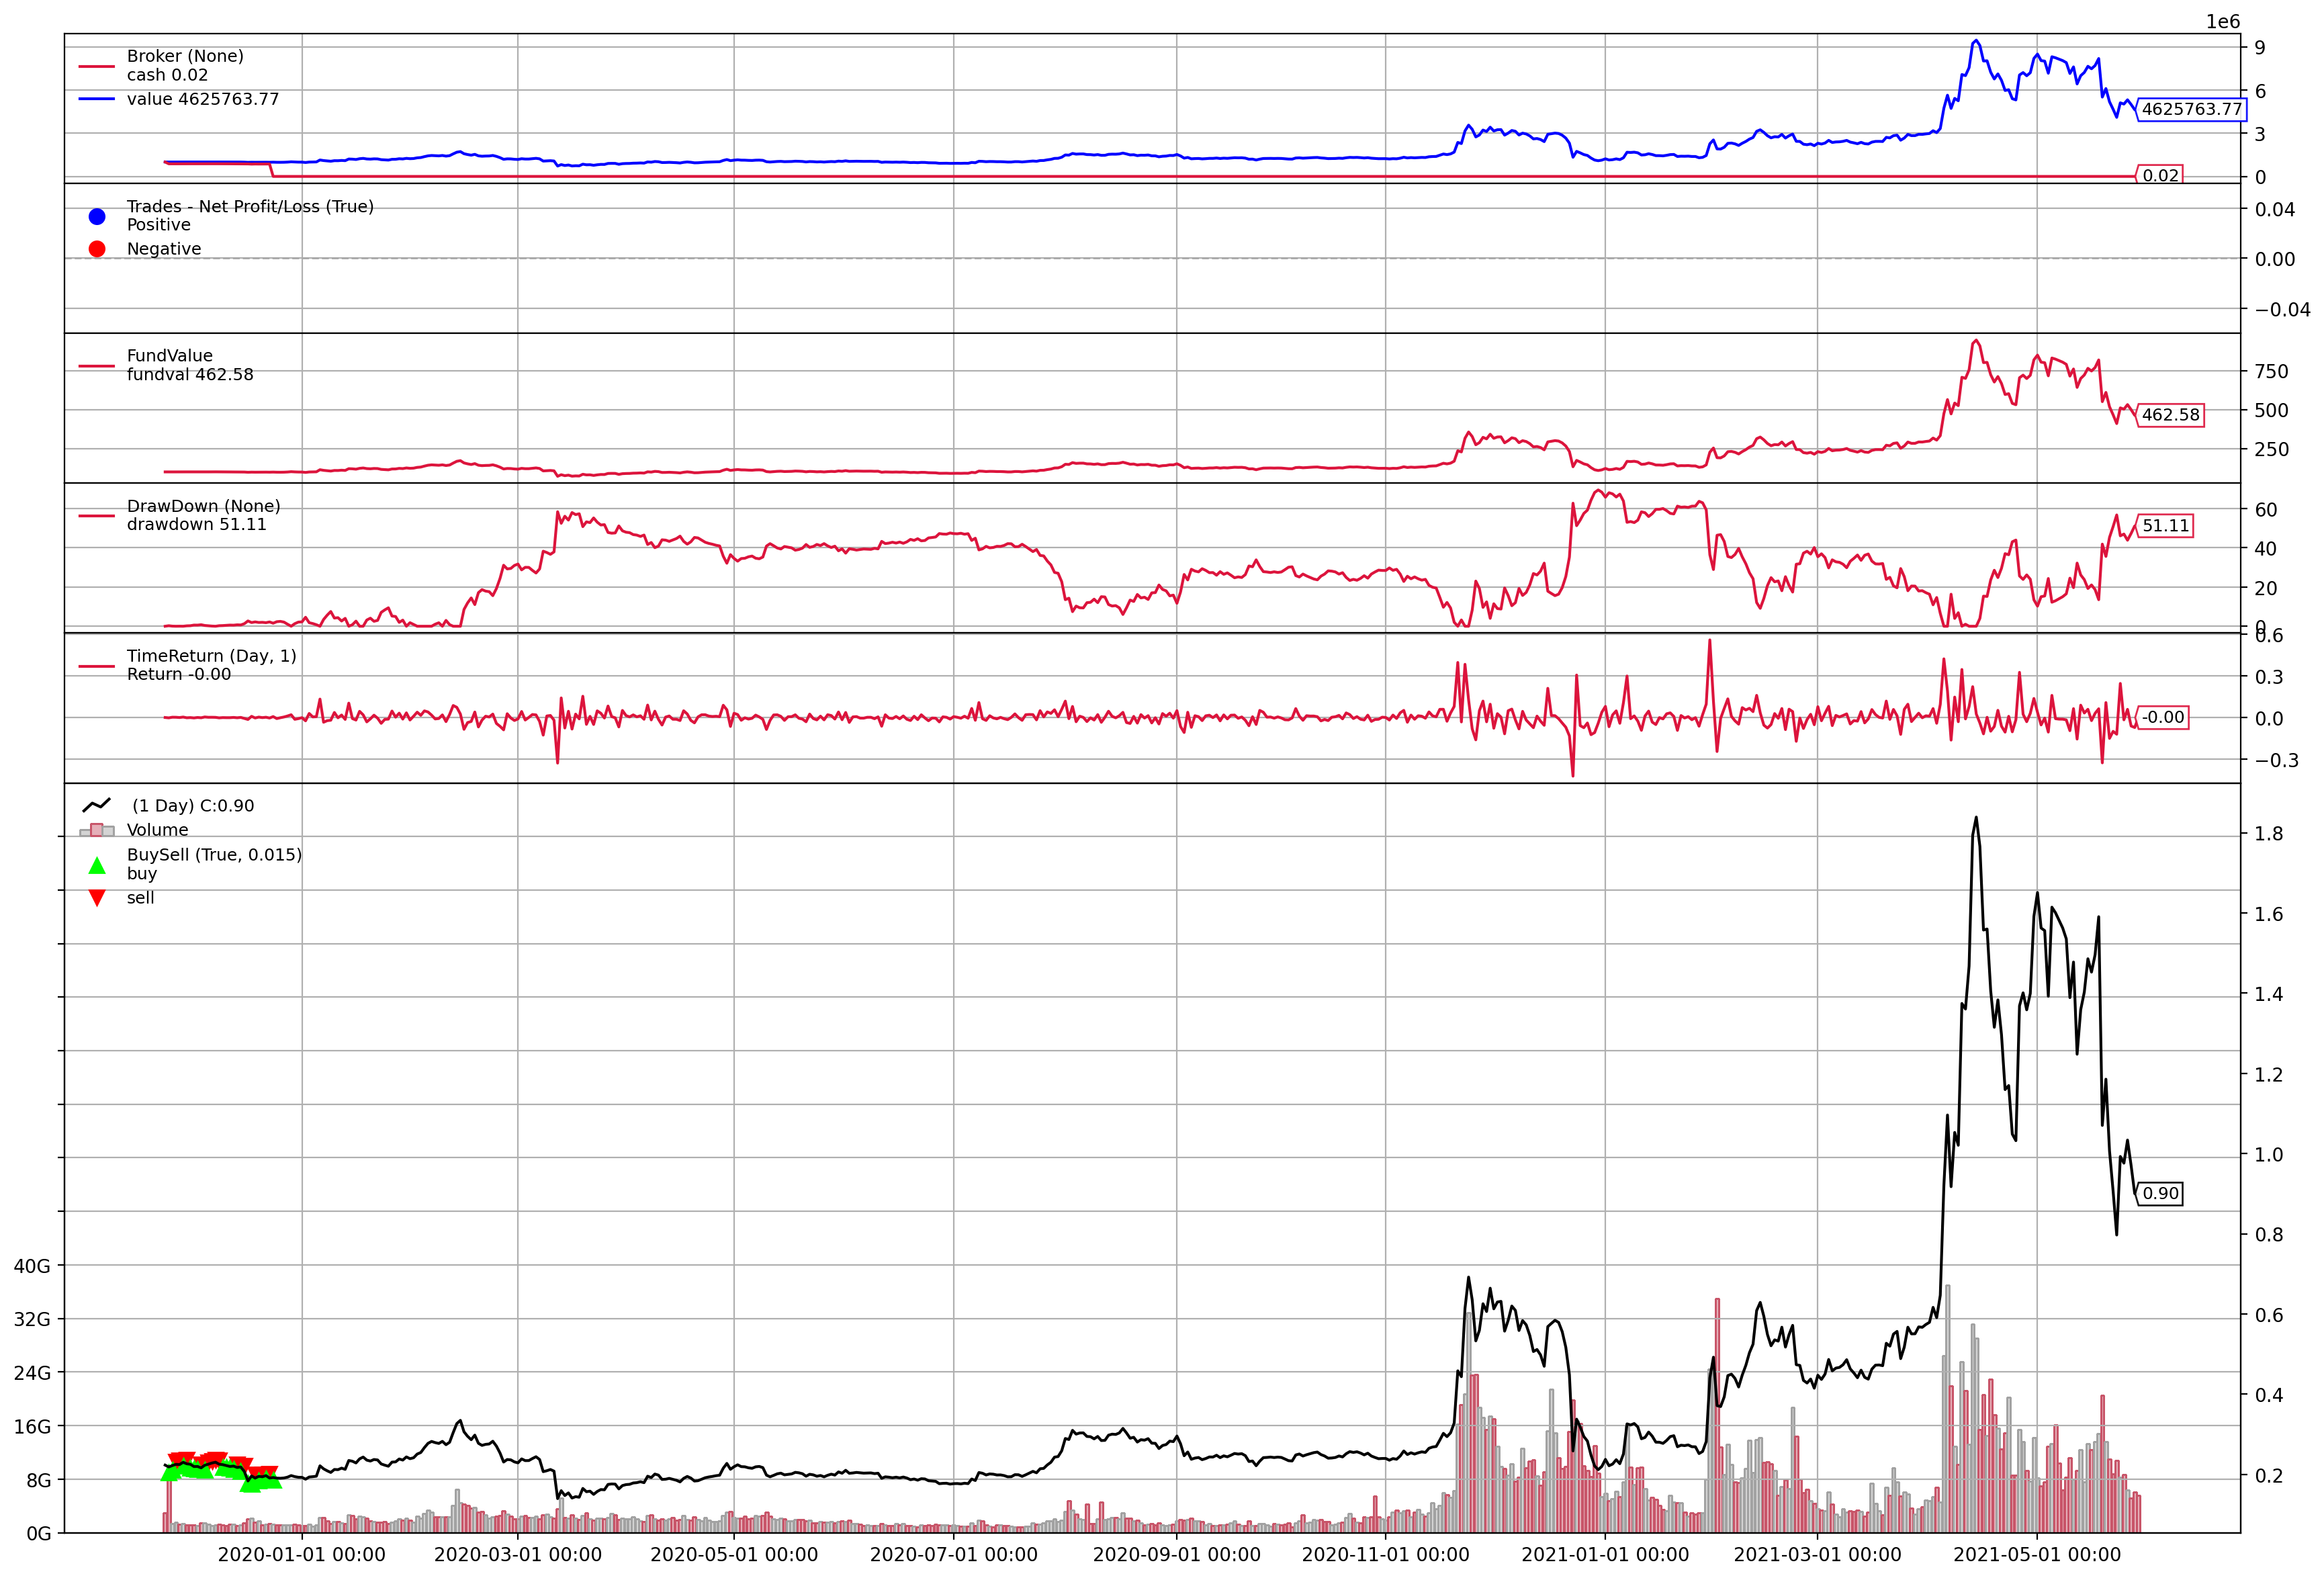

[[<Figure size 3600x2400 with 7 Axes>]]

In [ ]:
plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
cerebro.plot(start=dt.date(2019, 11, 24), iplot=False)

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2019-11-25',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### USD - LTC

In [ ]:
ltc_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/LTC-USD.csv', index_col=0, parse_dates=True)
ltc_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/LTC-USD_Predicted.csv', index_col=0, parse_dates=True)
train_len = len(ltc_data) - len(prediction_data)
train_len

1274

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=ltc_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2019-11-24T00:00:00, 
Current f 0.5
2019-11-25T00:00:00, BUY EXECUTED, Price: 44.73, Cost: 124987.43, Comm 0.00
2019-11-25T00:00:00, 
Current f 0.5
2019-11-26T00:00:00, SELL EXECUTED, Price: 45.83, Cost: 2594.59, Comm 0.00
2019-11-26T00:00:00, 
Current f 0.5
2019-11-27T00:00:00, SELL EXECUTED, Price: 47.27, Cost: 3265.60, Comm 0.00
2019-11-27T00:00:00, 
Current f 0.5
2019-11-28T00:00:00, SELL EXECUTED, Price: 48.01, Cost: 1565.70, Comm 0.00
2019-11-28T00:00:00, 
Current f 0.5
2019-11-29T00:00:00, BUY EXECUTED, Price: 47.06, Cost: 2117.56, Comm 0.00
2019-11-29T00:00:00, 
Current f 0.5
2019-11-30T00:00:00, SELL EXECUTED, Price: 48.88, Cost: 3850.51, Comm 0.00
2019-11-30T00:00:00, 
Current f 0.5
2019-12-01T00:00:00, BUY EXECUTED, Price: 47.48, Cost: 3133.38, Comm 0.00
2019-12-01T00:00:00, 
Current f 0.5
2019-12-02T00:00:00, SELL EXECUTED, Price: 47.71, Cost: 493.25, Comm 0.00
2019-12-02T00:00:00, 
Current f 0.5
2019-12-03T00:00:00, BUY EXECUTED, Price:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



2019-12-12T00:00:00, 
Current f 0.5
2019-12-13T00:00:00, SELL EXECUTED, Price: 44.08, Cost: 314.07, Comm 0.00
2019-12-13T00:00:00, 
Current f 0.5
2019-12-14T00:00:00, SELL EXECUTED, Price: 44.45, Cost: 942.20, Comm 0.00
2019-12-14T00:00:00, 
Current f 0.5
2019-12-15T00:00:00, BUY EXECUTED, Price: 43.72, Cost: 1748.89, Comm 0.00
2019-12-15T00:00:00, 
Current f 0.5
2019-12-16T00:00:00, SELL EXECUTED, Price: 43.76, Cost: 44.85, Comm 0.00
2019-12-16T00:00:00, 
Current f 0.5
2019-12-17T00:00:00, BUY EXECUTED, Price: 40.37, Cost: 8397.85, Comm 0.00
2019-12-17T00:00:00, 
Current f 0.5
2019-12-18T00:00:00, BUY EXECUTED, Price: 37.08, Cost: 8825.86, Comm 0.00
2019-12-18T00:00:00, 
Current f 0.5
2019-12-19T00:00:00, SELL EXECUTED, Price: 40.78, Cost: 11441.91, Comm 0.00
2019-12-19T00:00:00, 
Current f 0.5
2019-12-20T00:00:00, BUY EXECUTED, Price: 39.92, Cost: 2235.54, Comm 0.00
2019-12-20T00:00:00, 
Current f 0.5
2019-12-21T00:00:00, SELL EXECUTED, Price: 40.29, Cost: 1054.40, Comm 0.00
2019-12

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2019-11-25',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### USD - BCH

In [ ]:
bch_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/BCH-USD.csv', index_col=0, parse_dates=True)
bch_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/BCH-USD_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len

1274

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=bch_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-01-21T00:00:00, 
Current f 0.5
2021-01-22T00:00:00, BUY EXECUTED, Price: 419.59, Cost: 124616.79, Comm 0.00
2021-01-22T00:00:00, 
Current f 0.5
2021-01-23T00:00:00, SELL EXECUTED, Price: 441.53, Cost: 5035.02, Comm 0.00
2021-01-23T00:00:00, 
Current f 0.5
2021-01-24T00:00:00, BUY EXECUTED, Price: 431.50, Cost: 2157.52, Comm 0.00
2021-01-24T00:00:00, 
Current f 0.5
2021-01-25T00:00:00, SELL EXECUTED, Price: 440.10, Cost: 1679.16, Comm 0.00
2021-01-25T00:00:00, 
Current f 0.5
2021-01-26T00:00:00, BUY EXECUTED, Price: 433.80, Cost: 1301.41, Comm 0.00
2021-01-26T00:00:00, 
Current f 0.5
2021-01-27T00:00:00, BUY EXECUTED, Price: 428.04, Cost: 1284.13, Comm 0.00
2021-01-27T00:00:00, 
Current f 0.5
2021-01-28T00:00:00, BUY EXECUTED, Price: 378.03, Cost: 12853.03, Comm 0.00
2021-01-28T00:00:00, 
Current f 0.5
2021-01-29T00:00:00, SELL EXECUTED, Price: 391.80, Cost: 3740.76, Comm 0.00
2021-01-29T00:00:00, 
Current f 0.5
2021-01-30T00:00:00, SELL EXECUTE

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2021-02-18T00:00:00, 
Current f 0.5
2021-02-19T00:00:00, BUY EXECUTED, Price: 705.99, Cost: 705.99, Comm 0.00
2021-02-19T00:00:00, 
Current f 0.0
2021-02-20T00:00:00, SELL EXECUTED, Price: 720.82, Cost: 80200.36, Comm 0.00
2021-02-20T00:00:00, 
Current f 1.109138822452671e-16
2021-02-21T00:00:00, 
Current f 1.6637082336790066e-16
2021-02-22T00:00:00, 
Current f 0.0
2021-02-23T00:00:00, 
Current f 1.5250658808724227e-16
2021-02-24T00:00:00, 
Current f 2.7755575615628914e-17
2021-02-25T00:00:00, 
Current f 0.0
2021-02-26T00:00:00, 
Current f 3.882053641220129e-16
2021-02-27T00:00:00, 
Current f 1.3864235280658388e-16
2021-02-28T00:00:00, 
Current f 0.0
2021-03-01T00:00:00, 
Current f 3.191891195797325e-16
2021-03-02T00:00:00, 
Current f 6.238905876296275e-16
2021-03-03T00:00:00, 
Current f 2.218277644905342e-16
2021-03-04T00:00:00, 
Current f 2.218277644905342e-16
2021-03-05T00:00:00, 
Current f 3.188774114551429e-16
2021-03-06T00:00:00, 
Current f 1.6637082336790066e-16
2021-03-07T00:00

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2021-1-22',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### USD - ADA

In [ ]:
ada_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/ADA-USD.csv', index_col=0, parse_dates=True)
ada_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/ADA-USD_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(ada_data) - len(prediction_data)
train_len

931

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=ada_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2020-04-20T00:00:00, 
Current f 0.5
2020-04-21T00:00:00, BUY EXECUTED, Price: 0.03, Cost: 124999.99, Comm 0.00
2020-04-21T00:00:00, 
Current f 0.5
2020-04-22T00:00:00, SELL EXECUTED, Price: 0.03, Cost: 1648.46, Comm 0.00
2020-04-22T00:00:00, 
Current f 0.5
2020-04-23T00:00:00, SELL EXECUTED, Price: 0.04, Cost: 5488.31, Comm 0.00
2020-04-23T00:00:00, 
Current f 0.5
2020-04-24T00:00:00, SELL EXECUTED, Price: 0.04, Cost: 10276.20, Comm 0.00
2020-04-24T00:00:00, 
Current f 0.5
2020-04-25T00:00:00, SELL EXECUTED, Price: 0.04, Cost: 2839.80, Comm 0.00
2020-04-25T00:00:00, 
Current f 0.5
2020-04-26T00:00:00, SELL EXECUTED, Price: 0.04, Cost: 1167.08, Comm 0.00
2020-04-26T00:00:00, 
Current f 0.5
2020-04-27T00:00:00, SELL EXECUTED, Price: 0.05, Cost: 6856.86, Comm 0.00
2020-04-27T00:00:00, 
Current f 0.5
2020-04-28T00:00:00, SELL EXECUTED, Price: 0.05, Cost: 1311.23, Comm 0.00
2020-04-28T00:00:00, 
Current f 0.5
2020-04-29T00:00:00, SELL EXECUTED, Price: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


 0.5
2020-05-19T00:00:00, SELL EXECUTED, Price: 0.05, Cost: 4451.07, Comm 0.00
2020-05-19T00:00:00, 
Current f 4.0
2020-05-20T00:00:00, BUY EXECUTED, Price: 0.06, Cost: 929947.09, Comm 0.00
2020-05-20T00:00:00, 
Current f 4.0
2020-05-21T00:00:00, 
Current f 4.0
2020-05-22T00:00:00, 
Current f 4.0
2020-05-23T00:00:00, 
Current f 4.0
2020-05-24T00:00:00, 
Current f 3.9999999999999996
2020-05-25T00:00:00, 
Current f 4.0
2020-05-26T00:00:00, 
Current f 4.0
2020-05-27T00:00:00, 
Current f 4.0
2020-05-28T00:00:00, 
Current f 4.0
2020-05-29T00:00:00, 
Current f 4.0
2020-05-30T00:00:00, 
Current f 4.0
2020-05-31T00:00:00, 
Current f 4.0
2020-06-01T00:00:00, 
Current f 4.0
2020-06-02T00:00:00, 
Current f 4.0
2020-06-03T00:00:00, 
Current f 4.0
2020-06-04T00:00:00, 
Current f 4.0
2020-06-05T00:00:00, 
Current f 4.0
2020-06-06T00:00:00, 
Current f 4.0
2020-06-07T00:00:00, 
Current f 4.0
2020-06-08T00:00:00, 
Current f 4.0
2020-06-09T00:00:00, 
Current f 4.0
2020-06-10T00:00:00, 
Current f 3.99999

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-4-21',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### USD - BNB

In [ ]:
bnb_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/BNB-USD.csv', index_col=0, parse_dates=True)
bnb_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/BNB-USD_Predicted.csv', index_col=0, parse_dates=True)
train_len = len(bnb_data) - len(prediction_data)
train_len

979

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=bnb_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2020-03-30T00:00:00, 
Current f 0.5
2020-03-31T00:00:00, BUY EXECUTED, Price: 12.29, Cost: 124994.05, Comm 0.00
2020-03-31T00:00:00, 
Current f 0.5
2020-04-01T00:00:00, SELL EXECUTED, Price: 12.58, Cost: 2555.66, Comm 0.00
2020-04-01T00:00:00, 
Current f 0.5
2020-04-02T00:00:00, SELL EXECUTED, Price: 12.74, Cost: 1339.27, Comm 0.00
2020-04-02T00:00:00, 
Current f 0.5
2020-04-03T00:00:00, SELL EXECUTED, Price: 13.07, Cost: 2641.67, Comm 0.00
2020-04-03T00:00:00, 
Current f 0.5
2020-04-04T00:00:00, SELL EXECUTED, Price: 13.37, Cost: 2371.36, Comm 0.00
2020-04-04T00:00:00, 
Current f 0.5
2020-04-05T00:00:00, SELL EXECUTED, Price: 13.82, Cost: 3317.45, Comm 0.00
2020-04-05T00:00:00, 
Current f 0.5
2020-04-06T00:00:00, BUY EXECUTED, Price: 13.73, Cost: 714.17, Comm 0.00
2020-04-06T00:00:00, 
Current f 0.5
2020-04-07T00:00:00, SELL EXECUTED, Price: 15.08, Cost: 8876.99, Comm 0.00
2020-04-07T00:00:00, 
Current f 0.5
2020-04-08T00:00:00, BUY EXECUTED, Price

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Current f 5.551115123125783e-17
2020-04-30T00:00:00, SELL EXECUTED, Price: 17.49, Cost: 101151.37, Comm 0.00
2020-04-30T00:00:00, 
Current f 2.7755575615628914e-16
2020-05-01T00:00:00, 
Current f 8.318541168395033e-17
2020-05-02T00:00:00, 
Current f 0.0
2020-05-03T00:00:00, 
Current f 0.0
2020-05-04T00:00:00, 
Current f 2.218277644905342e-16
2020-05-05T00:00:00, 
Current f 1.1102230246251565e-16
2020-05-06T00:00:00, 
Current f 6.79347528752261e-16
2020-05-07T00:00:00, 
Current f 0.0
2020-05-08T00:00:00, 
Current f 0.0
2020-05-09T00:00:00, 
Current f 2.9114894089382615e-16
2020-05-10T00:00:00, 
Current f 1.6637082336790066e-16
2020-05-11T00:00:00, 
Current f 0.0
2020-05-12T00:00:00, 
Current f 8.318541168395033e-17
2020-05-13T00:00:00, 
Current f 1.3864235280658388e-16
2020-05-14T00:00:00, 
Current f 0.0
2020-05-15T00:00:00, 
Current f 0.0
2020-05-16T00:00:00, 
Current f 2.7728470561316776e-17
2020-05-17T00:00:00, 
Current f 1.3864235280658388e-16
2020-05-18T00:00:00, 
Current f 4.57966

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions, 
      transactions=transactions,
      live_start_date='2020-3-31',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: divide by zero encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: divide by zero encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


## Stocks (S&P 500 big cap)

### AAPL


In [ ]:
aapl_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/AAPL.csv', index_col=0, parse_dates=True)
aapl_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/AAPL_Predicted.csv', index_col=0, parse_dates=True)
train_len = len(aapl_data) - len(prediction_data)
train_len

1761

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=aapl_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-05-10T00:00:00, 
Current f 0.5
2018-05-11T00:00:00, BUY EXECUTED, Price: 47.51, Cost: 124998.80, Comm 0.00
2018-05-11T00:00:00, 
Current f 0.5
2018-05-14T00:00:00, BUY EXECUTED, Price: 47.15, Cost: 801.51, Comm 0.00
2018-05-14T00:00:00, 
Current f 0.5
2018-05-15T00:00:00, BUY EXECUTED, Price: 47.04, Cost: 282.22, Comm 0.00
2018-05-15T00:00:00, 
Current f 0.5
2018-05-16T00:00:00, BUY EXECUTED, Price: 46.61, Cost: 978.81, Comm 0.00
2018-05-16T00:00:00, 
Current f 0.5
2018-05-17T00:00:00, SELL EXECUTED, Price: 47.04, Cost: 997.49, Comm 0.00
2018-05-17T00:00:00, 
Current f 0.5
2018-05-18T00:00:00, BUY EXECUTED, Price: 46.75, Cost: 654.47, Comm 0.00
2018-05-18T00:00:00, 
Current f 0.5
2018-05-21T00:00:00, BUY EXECUTED, Price: 46.58, Cost: 419.20, Comm 0.00
2018-05-21T00:00:00, 
Current f 0.5
2018-05-22T00:00:00, SELL EXECUTED, Price: 46.91, Cost: 759.88, Comm 0.00
2018-05-22T00:00:00, 
Current f 0.5
2018-05-23T00:00:00, BUY EXECUTED, Price: 46.79, C

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Current f 0.5
2018-05-29T00:00:00, SELL EXECUTED, Price: 47.15, Cost: 237.45, Comm 0.00
2018-05-29T00:00:00, 
Current f 0.5
2018-05-30T00:00:00, BUY EXECUTED, Price: 46.97, Cost: 375.80, Comm 0.00
2018-05-30T00:00:00, 
Current f 0.5
2018-05-31T00:00:00, BUY EXECUTED, Price: 46.88, Cost: 234.38, Comm 0.00
2018-05-31T00:00:00, 
Current f 0.5
2018-06-01T00:00:00, BUY EXECUTED, Price: 46.72, Cost: 373.74, Comm 0.00
2018-06-01T00:00:00, 
Current f 0.5
2018-06-04T00:00:00, SELL EXECUTED, Price: 47.56, Cost: 1946.92, Comm 0.00
2018-06-04T00:00:00, 
Current f 0.5
2018-06-05T00:00:00, SELL EXECUTED, Price: 47.96, Cost: 902.23, Comm 0.00
2018-06-05T00:00:00, 
Current f 0.5
2018-06-06T00:00:00, SELL EXECUTED, Price: 48.33, Cost: 807.26, Comm 0.00
2018-06-06T00:00:00, 
Current f 0.5
2018-06-07T00:00:00, SELL EXECUTED, Price: 48.49, Cost: 379.89, Comm 0.00
2018-06-07T00:00:00, 
Current f 0.5
2018-06-08T00:00:00, BUY EXECUTED, Price: 48.37, Cost: 241.83, Comm 0.00
2018-06-08T00:00:00, 
Current f 0.5

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions, 
      transactions=transactions,
      live_start_date='2018-5-11',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### FB


In [ ]:
fb_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/FB.csv', index_col=0, parse_dates=True)
fb_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/FB_Predicted.csv', index_col=0, parse_dates=True)
train_len = len(fb_data) - len(prediction_data)
train_len

1584

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=fb_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-09-05T00:00:00, 
Current f 0.5
2018-09-06T00:00:00, BUY EXECUTED, Price: 167.18, Cost: 124883.45, Comm 0.00
2018-09-06T00:00:00, 
Current f 0.5
2018-09-07T00:00:00, BUY EXECUTED, Price: 162.53, Cost: 3088.07, Comm 0.00
2018-09-07T00:00:00, 
Current f 0.5
2018-09-10T00:00:00, SELL EXECUTED, Price: 163.04, Cost: 167.06, Comm 0.00
2018-09-10T00:00:00, 
Current f 0.5
2018-09-11T00:00:00, SELL EXECUTED, Price: 164.18, Cost: 835.32, Comm 0.00
2018-09-11T00:00:00, 
Current f 0.5
2018-09-12T00:00:00, SELL EXECUTED, Price: 165.94, Cost: 1169.45, Comm 0.00
2018-09-12T00:00:00, 
Current f 0.5
2018-09-13T00:00:00, BUY EXECUTED, Price: 162.00, Cost: 2430.00, Comm 0.00
2018-09-13T00:00:00, 
Current f 0.5
2018-09-14T00:00:00, BUY EXECUTED, Price: 161.36, Cost: 484.08, Comm 0.00
2018-09-14T00:00:00, 
Current f 0.5
2018-09-17T00:00:00, SELL EXECUTED, Price: 162.32, Cost: 500.83, Comm 0.00
2018-09-17T00:00:00, 
Current f 0.5
2018-09-18T00:00:00, BUY EXECUTED, Pr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Current f 0.5
2018-09-20T00:00:00, SELL EXECUTED, Price: 163.06, Cost: 1668.86, Comm 0.00
2018-09-20T00:00:00, 
Current f 0.5
2018-09-21T00:00:00, SELL EXECUTED, Price: 166.02, Cost: 2002.63, Comm 0.00
2018-09-21T00:00:00, 
Current f 0.5
2018-09-24T00:00:00, BUY EXECUTED, Price: 162.93, Cost: 1792.23, Comm 0.00
2018-09-24T00:00:00, 
Current f 0.5
2018-09-25T00:00:00, SELL EXECUTED, Price: 165.41, Cost: 1501.46, Comm 0.00
2018-09-25T00:00:00, 
Current f 0.5
2018-09-26T00:00:00, BUY EXECUTED, Price: 164.91, Cost: 164.91, Comm 0.00
2018-09-26T00:00:00, 
Current f 0.5
2018-09-27T00:00:00, SELL EXECUTED, Price: 166.95, Cost: 1167.79, Comm 0.00
2018-09-27T00:00:00, 
Current f 0.5
2018-09-28T00:00:00, SELL EXECUTED, Price: 168.84, Cost: 1167.79, Comm 0.00
2018-09-28T00:00:00, 
Current f 0.5
2018-10-01T00:00:00, BUY EXECUTED, Price: 164.46, Cost: 2631.36, Comm 0.00
2018-10-01T00:00:00, 
Current f 0.5
2018-10-02T00:00:00, BUY EXECUTED, Price: 162.44, Cost: 1299.52, Comm 0.00
2018-10-02T00:00:00

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions, 
      transactions=transactions,
      live_start_date='2018-9-6',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### TSLA


In [ ]:
tsla_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/TSLA.csv', index_col=0, parse_dates=True)
tsla_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/TSLA_Predicted.csv', index_col=0, parse_dates=True)
train_len = len(tsla_data) - len(prediction_data)
train_len

1761

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=tsla_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-05-18T00:00:00, 
Current f 0.5
2018-05-21T00:00:00, BUY EXECUTED, Price: 55.36, Cost: 124956.54, Comm 0.00
2018-05-21T00:00:00, 
Current f 0.5
2018-05-22T00:00:00, SELL EXECUTED, Price: 56.90, Cost: 2878.93, Comm 0.00
2018-05-22T00:00:00, 
Current f 0.5
2018-05-23T00:00:00, BUY EXECUTED, Price: 55.00, Cost: 3630.13, Comm 0.00
2018-05-23T00:00:00, 
Current f 0.5
2018-05-24T00:00:00, SELL EXECUTED, Price: 55.81, Cost: 1549.90, Comm 0.00
2018-05-24T00:00:00, 
Current f 0.5
2018-05-25T00:00:00, BUY EXECUTED, Price: 55.57, Cost: 388.99, Comm 0.00
2018-05-25T00:00:00, 
Current f 0.5
2018-05-29T00:00:00, SELL EXECUTED, Price: 55.77, Cost: 332.12, Comm 0.00
2018-05-29T00:00:00, 
Current f 0.5
2018-05-30T00:00:00, SELL EXECUTED, Price: 56.75, Cost: 1882.04, Comm 0.00
2018-05-30T00:00:00, 
Current f 0.5
2018-05-31T00:00:00, SELL EXECUTED, Price: 58.34, Cost: 2933.77, Comm 0.00
2018-05-31T00:00:00, 
Current f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


 0.5
2018-06-01T00:00:00, BUY EXECUTED, Price: 56.95, Cost: 2619.52, Comm 0.00
2018-06-01T00:00:00, 
Current f 0.5
2018-06-04T00:00:00, SELL EXECUTED, Price: 58.36, Cost: 2547.82, Comm 0.00
2018-06-04T00:00:00, 
Current f 0.5
2018-06-05T00:00:00, SELL EXECUTED, Price: 59.35, Cost: 1717.01, Comm 0.00
2018-06-05T00:00:00, 
Current f 0.5
2018-06-06T00:00:00, BUY EXECUTED, Price: 58.23, Cost: 1979.68, Comm 0.00
2018-06-06T00:00:00, 
Current f 0.5
2018-06-07T00:00:00, SELL EXECUTED, Price: 63.90, Cost: 9201.72, Comm 0.00
2018-06-07T00:00:00, 
Current f 0.5
2018-06-08T00:00:00, BUY EXECUTED, Price: 63.22, Cost: 1074.71, Comm 0.00
2018-06-08T00:00:00, 
Current f 0.5
2018-06-11T00:00:00, SELL EXECUTED, Price: 63.53, Cost: 388.49, Comm 0.00
2018-06-11T00:00:00, 
Current f 0.5
2018-06-12T00:00:00, SELL EXECUTED, Price: 66.42, Cost: 4273.34, Comm 0.00
2018-06-12T00:00:00, 
Current f 0.5
2018-06-13T00:00:00, SELL EXECUTED, Price: 68.55, Cost: 2885.89, Comm 0.00
2018-06-13T00:00:00, 
Current f 0.5


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions, 
      transactions=transactions,
      live_start_date='2018-5-19',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### GOOGL


In [ ]:
googl_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/GOOGL.csv', index_col=0, parse_dates=True)
googl_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/GOOGL_Predicted.csv', index_col=0, parse_dates=True)
train_len = len(googl_data) - len(prediction_data)
train_len

1761

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=googl_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-05-18T00:00:00, 
Current f 0.5
2018-05-21T00:00:00, BUY EXECUTED, Price: 1069.64, Cost: 124078.24, Comm 0.00
2018-05-21T00:00:00, 
Current f 0.5
2018-05-22T00:00:00, 
Current f 0.5
2018-05-23T00:00:00, 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Current f 0.5
2018-05-24T00:00:00, 
Current f 0.5
2018-05-25T00:00:00, 
Current f 0.5
2018-05-29T00:00:00, 
Current f 0.5
2018-05-30T00:00:00, BUY EXECUTED, Price: 1068.07, Cost: 1068.07, Comm 0.00
2018-05-30T00:00:00, 
Current f 0.5
2018-05-31T00:00:00, 
Current f 0.5
2018-06-01T00:00:00, SELL EXECUTED, Price: 1100.00, Cost: 2139.25, Comm 0.00
2018-06-01T00:00:00, 
Current f 0.5
2018-06-04T00:00:00, SELL EXECUTED, Price: 1135.00, Cost: 4278.51, Comm 0.00
2018-06-04T00:00:00, 
Current f 0.5
2018-06-05T00:00:00, SELL EXECUTED, Price: 1153.04, Cost: 1069.63, Comm 0.00
2018-06-05T00:00:00, 
Current f 0.5
2018-06-06T00:00:00, 
Current f 0.5
2018-06-07T00:00:00, 
Current f 0.5
2018-06-08T00:00:00, BUY EXECUTED, Price: 1134.42, Cost: 1134.42, Comm 0.00
2018-06-08T00:00:00, 
Current f 0.5
2018-06-11T00:00:00, 
Current f 0.5
2018-06-12T00:00:00, 
Current f 0.5
2018-06-13T00:00:00, SELL EXECUTED, Price: 1148.19, Cost: 1070.21, Comm 0.00
2018-06-13T00:00:00, 
Current f 0.5
2018-06-14T00:00:00, 


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions, 
      transactions=transactions,
      live_start_date='2018-5-19',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### BRK-B


In [ ]:
brkb_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/BRK-B.csv', index_col=0, parse_dates=True)
brkb_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/BRK-B_Predicted.csv', index_col=0, parse_dates=True)
train_len = len(brkb_data) - len(prediction_data)
train_len

1761

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=brkb_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-05-18T00:00:00, 
Current f 0.5
2018-05-21T00:00:00, BUY EXECUTED, Price: 196.06, Cost: 124890.22, Comm 0.00
2018-05-21T00:00:00, 
Current f 0.5
2018-05-22T00:00:00, SELL EXECUTED, Price: 197.91, Cost: 784.24, Comm 0.00
2018-05-22T00:00:00, 
Current f 0.5
2018-05-23T00:00:00, SELL EXECUTED, Price: 198.13, Cost: 196.06, Comm 0.00
2018-05-23T00:00:00, 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Current f 0.5
2018-05-24T00:00:00, BUY EXECUTED, Price: 195.95, Cost: 979.75, Comm 0.00
2018-05-24T00:00:00, 
Current f 0.5
2018-05-25T00:00:00, BUY EXECUTED, Price: 194.83, Cost: 779.32, Comm 0.00
2018-05-25T00:00:00, 
Current f 0.5
2018-05-29T00:00:00, BUY EXECUTED, Price: 194.15, Cost: 388.30, Comm 0.00
2018-05-29T00:00:00, 
Current f 0.5
2018-05-30T00:00:00, BUY EXECUTED, Price: 189.87, Cost: 2278.44, Comm 0.00
2018-05-30T00:00:00, 
Current f 0.5
2018-05-31T00:00:00, SELL EXECUTED, Price: 194.10, Cost: 2155.26, Comm 0.00
2018-05-31T00:00:00, 
Current f 0.5
2018-06-01T00:00:00, BUY EXECUTED, Price: 191.53, Cost: 1149.18, Comm 0.00
2018-06-01T00:00:00, 
Current f 0.5
2018-06-04T00:00:00, SELL EXECUTED, Price: 192.23, Cost: 195.89, Comm 0.00
2018-06-04T00:00:00, 
Current f 0.5
2018-06-05T00:00:00, BUY EXECUTED, Price: 191.30, Cost: 382.60, Comm 0.00
2018-06-05T00:00:00, 
Current f 0.5
2018-06-06T00:00:00, BUY EXECUTED, Price: 190.77, Cost: 381.54, Comm 0.00
2018-06-06T00:00:00, 
Curre

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions, 
      transactions=transactions,
      live_start_date='2018-5-19',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### JPM


In [ ]:
jpm_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/JPM.csv', index_col=0, parse_dates=True)
jpm_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/JPM_Predicted.csv', index_col=0, parse_dates=True)
train_len = len(jpm_data) - len(prediction_data)
train_len

1761

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=jpm_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-05-18T00:00:00, 
Current f 0.5
2018-05-21T00:00:00, BUY EXECUTED, Price: 111.13, Cost: 124910.12, Comm 0.00
2018-05-21T00:00:00, 
Current f 0.5
2018-05-22T00:00:00, SELL EXECUTED, Price: 112.15, Cost: 889.04, Comm 0.00
2018-05-22T00:00:00, 
Current f 0.5
2018-05-23T00:00:00, SELL EXECUTED, Price: 113.01, Cost: 777.91, Comm 0.00
2018-05-23T00:00:00, 
Current f 0.5
2018-05-24T00:00:00, BUY EXECUTED, Price: 112.49, Cost: 337.47, Comm 0.00
2018-05-24T00:00:00, 
Current f 0.5
2018-05-25T00:00:00, BUY EXECUTED, Price: 111.23, Cost: 1223.53, Comm 0.00
2018-05-25T00:00:00, 
Current f 0.5
2018-05-29T00:00:00, BUY EXECUTED, Price: 110.66, Cost: 663.96, Comm 0.00
2018-05-29T00:00:00, 
Current f 0.5
2018-05-30T00:00:00, BUY EXECUTED, Price: 105.93, Cost: 4660.92, Comm 0.00
2018-05-30T00:00:00, 
Current f 0.5
2018-05-31T00:00:00, SELL EXECUTED, Price: 108.35, Cost: 2440.61, Comm 0.00
2018-05-31T00:00:00, 
Current f 0.5
2018-06-01T00:00:00, BUY EXECUTED, Pri

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Current f 3.9999999999999996
2018-07-13T00:00:00, 
Current f 4.0
2018-07-16T00:00:00, 
Current f 0.0
2018-07-17T00:00:00, SELL EXECUTED, Price: 110.58, Cost: 999778.12, Comm 0.00
2018-07-17T00:00:00, 
Current f 2.7755575615628914e-16
2018-07-18T00:00:00, 
Current f 1.6637082336790066e-16
2018-07-19T00:00:00, 
Current f 0.0
2018-07-20T00:00:00, 
Current f 0.0
2018-07-23T00:00:00, 
Current f 5.551115123125783e-17
2018-07-24T00:00:00, 
Current f 3.604701172971181e-16
2018-07-25T00:00:00, 
Current f 0.0
2018-07-26T00:00:00, 
Current f 0.0
2018-07-27T00:00:00, 
Current f 0.0
2018-07-30T00:00:00, 
Current f 5.551115123125783e-17
2018-07-31T00:00:00, 
Current f 0.0
2018-08-01T00:00:00, 
Current f 2.49556235051851e-16
2018-08-02T00:00:00, 
Current f 1.3864235280658388e-16
2018-08-03T00:00:00, 
Current f 0.0
2018-08-06T00:00:00, 
Current f 0.0
2018-08-07T00:00:00, 
Current f 1.6637082336790066e-16
2018-08-08T00:00:00, 
Current f 5.545694112263355e-17
2018-08-09T00:00:00, 
Current f 0.0
2018-08-

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions, 
      transactions=transactions,
      live_start_date='2018-5-19',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### JNJ


In [ ]:
jnj_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/JNJ.csv', index_col=0, parse_dates=True)
jnj_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/JNJ_Predicted.csv', index_col=0, parse_dates=True)
train_len = len(jnj_data) - len(prediction_data)
train_len

1761

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=jnj_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-05-18T00:00:00, 
Current f 0.5
2018-05-21T00:00:00, BUY EXECUTED, Price: 124.24, Cost: 124985.44, Comm 0.00
2018-05-21T00:00:00, 
Current f 0.5
2018-05-22T00:00:00, BUY EXECUTED, Price: 123.72, Cost: 371.16, Comm 0.00
2018-05-22T00:00:00, 
Current f 0.5
2018-05-23T00:00:00, BUY EXECUTED, Price: 122.91, Cost: 737.46, Comm 0.00
2018-05-23T00:00:00, 
Current f 0.5
2018-05-24T00:00:00, SELL EXECUTED, Price: 123.45, Cost: 372.69, Comm 0.00
2018-05-24T00:00:00, 
Current f 0.5
2018-05-25T00:00:00, BUY EXECUTED, Price: 122.25, Cost: 978.00, Comm 0.00
2018-05-25T00:00:00, 
Current f 0.5
2018-05-29T00:00:00, BUY EXECUTED, Price: 121.47, Cost: 728.82, Comm 0.00
2018-05-29T00:00:00, 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Current f 0.5
2018-05-30T00:00:00, BUY EXECUTED, Price: 119.40, Cost: 1791.00, Comm 0.00
2018-05-30T00:00:00, 
Current f 0.5
2018-05-31T00:00:00, SELL EXECUTED, Price: 120.97, Cost: 1365.43, Comm 0.00
2018-05-31T00:00:00, 
Current f 0.5
2018-06-01T00:00:00, BUY EXECUTED, Price: 119.62, Cost: 1196.20, Comm 0.00
2018-06-01T00:00:00, 
Current f 0.5
2018-06-04T00:00:00, SELL EXECUTED, Price: 121.26, Cost: 1489.04, Comm 0.00
2018-06-04T00:00:00, 
Current f 0.5
2018-06-05T00:00:00, SELL EXECUTED, Price: 121.95, Cost: 620.43, Comm 0.00
2018-06-05T00:00:00, 
Current f 0.5
2018-06-06T00:00:00, BUY EXECUTED, Price: 121.48, Cost: 364.44, Comm 0.00
2018-06-06T00:00:00, 
Current f 0.5
2018-06-07T00:00:00, SELL EXECUTED, Price: 122.79, Cost: 1116.71, Comm 0.00
2018-06-07T00:00:00, 
Current f 0.5
2018-06-08T00:00:00, SELL EXECUTED, Price: 123.33, Cost: 496.32, Comm 0.00
2018-06-08T00:00:00, 
Current f 0.5
2018-06-11T00:00:00, SELL EXECUTED, Price: 124.06, Cost: 620.39, Comm 0.00
2018-06-11T00:00:00, 

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions, 
      transactions=transactions,
      live_start_date='2018-5-19',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


###SPY

In [ ]:
spy_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/SPY.csv', index_col=0, parse_dates=True)
spy_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/0700_Predicted.csv', index_col=0, parse_dates=True)
train_len = len(spy_data) - len(prediction_data)
train_len

1775

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=spy_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-06-08T00:00:00, 
Current f 0.5
2018-06-11T00:00:00, BUY EXECUTED, Price: 278.19, Cost: 124907.31, Comm 0.00
2018-06-11T00:00:00, 
Current f 0.5
2018-06-12T00:00:00, 
Current f 0.5
2018-06-13T00:00:00, 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Current f 0.5
2018-06-14T00:00:00, 
Current f 0.5
2018-06-15T00:00:00, 
Current f 0.5
2018-06-18T00:00:00, BUY EXECUTED, Price: 277.13, Cost: 277.13, Comm 0.00
2018-06-18T00:00:00, 
Current f 0.5
2018-06-19T00:00:00, BUY EXECUTED, Price: 276.56, Cost: 276.56, Comm 0.00
2018-06-19T00:00:00, 
Current f 0.5
2018-06-20T00:00:00, BUY EXECUTED, Price: 275.50, Cost: 551.00, Comm 0.00
2018-06-20T00:00:00, 
Current f 0.5
2018-06-21T00:00:00, 
Current f 0.5
2018-06-22T00:00:00, BUY EXECUTED, Price: 274.24, Cost: 274.24, Comm 0.00
2018-06-22T00:00:00, 
Current f 0.5
2018-06-25T00:00:00, 
Current f 0.5
2018-06-26T00:00:00, BUY EXECUTED, Price: 271.00, Cost: 1355.00, Comm 0.00
2018-06-26T00:00:00, 
Current f 0.5
2018-06-27T00:00:00, 
Current f 0.5
2018-06-28T00:00:00, BUY EXECUTED, Price: 269.35, Cost: 808.05, Comm 0.00
2018-06-28T00:00:00, 
Current f 0.5
2018-06-29T00:00:00, SELL EXECUTED, Price: 270.89, Cost: 556.06, Comm 0.00
2018-06-29T00:00:00, 
Current f 0.5
2018-07-02T00:00:00, 
Current f 0.

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions, 
      transactions=transactions,
      live_start_date='2018-6-10',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


## Stocks (HSI Top)

### 0700 (Tencent)

In [ ]:
tencent_data = pd.read_csv(r'/content/drive/My Drive/CFE/0700.HK.csv', index_col=0, parse_dates=True)
tencent_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/0700_Predicted.csv', index_col=0, parse_dates=True)
train_len = len(tencent_data) - len(prediction_data)
train_len

494

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = tencent_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-05-16T00:00:00, 
Current f 0.5
2018-05-17T00:00:00, BUY EXECUTED, Price: 396.20, Cost: 124803.00, Comm 0.00
2018-05-17T00:00:00, 
Current f 0.5
2018-05-18T00:00:00, SELL EXECUTED, Price: 411.00, Cost: 3565.80, Comm 0.00
2018-05-18T00:00:00, 
Current f 0.5
2018-05-21T00:00:00, 
Current f 0.5
2018-05-23T00:00:00, BUY EXECUTED, Price: 408.00, Cost: 408.00, Comm 0.00
2018-05-23T00:00:00, 
Current f 0.5
2018-05-24T00:00:00, BUY EXECUTED, Price: 407.00, Cost: 407.00, Comm 0.00
2018-05-24T00:00:00, 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Current f 0.5
2018-05-25T00:00:00, 
Current f 0.5
2018-05-28T00:00:00, BUY EXECUTED, Price: 404.00, Cost: 808.00, Comm 0.00
2018-05-28T00:00:00, 
Current f 0.5
2018-05-29T00:00:00, 
Current f 0.5
2018-05-30T00:00:00, BUY EXECUTED, Price: 402.00, Cost: 402.00, Comm 0.00
2018-05-30T00:00:00, 
Current f 0.5
2018-05-31T00:00:00, BUY EXECUTED, Price: 395.00, Cost: 1975.00, Comm 0.00
2018-05-31T00:00:00, 
Current f 0.5
2018-06-01T00:00:00, SELL EXECUTED, Price: 399.20, Cost: 792.64, Comm 0.00
2018-06-01T00:00:00, 
Current f 0.5
2018-06-04T00:00:00, SELL EXECUTED, Price: 404.00, Cost: 1188.96, Comm 0.00
2018-06-04T00:00:00, 
Current f 0.5
2018-06-05T00:00:00, SELL EXECUTED, Price: 415.00, Cost: 2774.24, Comm 0.00
2018-06-05T00:00:00, 
Current f 0.5
2018-06-06T00:00:00, SELL EXECUTED, Price: 420.00, Cost: 1585.28, Comm 0.00
2018-06-06T00:00:00, 
Current f 0.5
2018-06-07T00:00:00, SELL EXECUTED, Price: 425.00, Cost: 1188.96, Comm 0.00
2018-06-07T00:00:00, 
Current f 0.5
2018-06-08T00:00:00, SEL

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-05-17',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### 1398 (ICBC)

In [ ]:
icbc_data = pd.read_csv(r'/content/drive/My Drive/CFE/1398.HK.csv', index_col=0, parse_dates=True)
icbc_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/1398_Predicted.csv', index_col=0, parse_dates=True)
train_len = len(icbc_data) - len(prediction_data)
train_len

494

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = icbc_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-05-16T00:00:00, 
Current f 0.5
2018-05-17T00:00:00, BUY EXECUTED, Price: 6.88, Cost: 124995.84, Comm 0.00
2018-05-17T00:00:00, 
Current f 0.5
2018-05-18T00:00:00, BUY EXECUTED, Price: 6.75, Cost: 2065.50, Comm 0.00
2018-05-18T00:00:00, 
Current f 0.5
2018-05-21T00:00:00, 
Current f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


 0.5
2018-05-23T00:00:00, BUY EXECUTED, Price: 6.74, Cost: 161.76, Comm 0.00
2018-05-23T00:00:00, 
Current f 0.5
2018-05-24T00:00:00, BUY EXECUTED, Price: 6.63, Cost: 1783.47, Comm 0.00
2018-05-24T00:00:00, 
Current f 0.5
2018-05-25T00:00:00, SELL EXECUTED, Price: 6.65, Cost: 336.83, Comm 0.00
2018-05-25T00:00:00, 
Current f 0.5
2018-05-28T00:00:00, BUY EXECUTED, Price: 6.62, Cost: 489.88, Comm 0.00
2018-05-28T00:00:00, 
Current f 0.5
2018-05-29T00:00:00, SELL EXECUTED, Price: 6.63, Cost: 164.95, Comm 0.00
2018-05-29T00:00:00, 
Current f 0.5
2018-05-30T00:00:00, BUY EXECUTED, Price: 6.54, Cost: 1471.50, Comm 0.00
2018-05-30T00:00:00, 
Current f 0.5
2018-05-31T00:00:00, BUY EXECUTED, Price: 6.41, Cost: 2160.17, Comm 0.00
2018-05-31T00:00:00, 
Current f 0.5
2018-06-01T00:00:00, SELL EXECUTED, Price: 6.50, Cost: 1598.65, Comm 0.00
2018-06-01T00:00:00, 
Current f 0.5
2018-06-04T00:00:00, SELL EXECUTED, Price: 6.51, Cost: 178.39, Comm 0.00
2018-06-04T00:00:00, 
Current f 0.5
2018-06-05T00:0

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-05-17',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### 4333 (CISCO-T)

In [ ]:
cisco_data = pd.read_csv(r'/content/drive/My Drive/CFE/4333.HK.csv', index_col=0, parse_dates=True)
cisco_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/4333_Predicted.csv', index_col=0, parse_dates=True)
train_len = len(cisco_data) - len(prediction_data)
train_len

494

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = cisco_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-05-16T00:00:00, 
Current f 0.5
2018-05-17T00:00:00, BUY EXECUTED, Price: 215.00, Cost: 124915.00, Comm 0.00
2018-05-17T00:00:00, 
Current f 0.5
2018-05-18T00:00:00, 
Current f 0.5
2018-05-21T00:00:00, 
Current f 0.5
2018-05-23T00:00:00, SELL EXECUTED, Price: 270.00, Cost: 22145.00, Comm 0.00
2018-05-23T00:00:00, 
Current f 0.5
2018-05-24T00:00:00, 
Current f 0.5
2018-05-25T00:00:00, 
Current f 0.5
2018-05-28T00:00:00, 
Current f 0.5
2018-05-29T00:00:00, 
Current f 0.5
2018-05-30T00:00:00, 
Current f 0.5
2018-05-31T00:00:00, 
Current f 0.5
2018-06-01T00:00:00, 
Current f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


 0.5
2018-06-04T00:00:00, 
Current f 0.5
2018-06-05T00:00:00, 
Current f 0.5
2018-06-06T00:00:00, 
Current f 0.5
2018-06-07T00:00:00, 
Current f 0.5
2018-06-08T00:00:00, 
Current f 0.5
2018-06-11T00:00:00, 
Current f 0.5
2018-06-12T00:00:00, 
Current f 0.5
2018-06-13T00:00:00, 
Current f 0.5
2018-06-14T00:00:00, 
Current f 0.5
2018-06-15T00:00:00, 
Current f 0.5
2018-06-19T00:00:00, 
Current f 0.5
2018-06-20T00:00:00, 
Current f 0.5
2018-06-21T00:00:00, 
Current f 0.5
2018-06-22T00:00:00, 
Current f 0.5
2018-06-25T00:00:00, 
Current f 0.5
2018-06-26T00:00:00, 
Current f 0.5
2018-06-27T00:00:00, 
Current f 0.5
2018-06-28T00:00:00, 
Current f 0.0
2018-06-29T00:00:00, SELL EXECUTED, Price: 270.00, Cost: 102770.00, Comm 0.00
2018-06-29T00:00:00, 
Current f 0.0
2018-07-03T00:00:00, 
Current f 0.0
2018-07-04T00:00:00, 
Current f 0.5
2018-07-05T00:00:00, BUY EXECUTED, Price: 270.00, Cost: 128790.00, Comm 0.00
2018-07-05T00:00:00, 
Current f 0.5
2018-07-06T00:00:00, 
Current f 0.5
2018-07-09T0

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-05-17',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### 3968 (CM Bank)

In [ ]:
cm_data = pd.read_csv(r'/content/drive/My Drive/CFE/3968.HK.csv', index_col=0, parse_dates=True)
cm_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/3968_Predicted.csv', index_col=0, parse_dates=True)
train_len = len(cm_data) - len(prediction_data)
train_len

494

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = cm_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-05-16T00:00:00, 
Current f 0.5
2018-05-17T00:00:00, BUY EXECUTED, Price: 34.60, Cost: 124975.19, Comm 0.00
2018-05-17T00:00:00, 
Current f 0.5
2018-05-18T00:00:00, BUY EXECUTED, Price: 33.85, Cost: 2369.50, Comm 0.00
2018-05-18T00:00:00, 
Current f 0.5
2018-05-21T00:00:00, SELL EXECUTED, Price: 34.15, Cost: 933.81, Comm 0.00
2018-05-21T00:00:00, 
Current f 0.5
2018-05-23T00:00:00, SELL EXECUTED, Price: 34.35, Cost: 657.13, Comm 0.00
2018-05-23T00:00:00, 
Current f 0.5
2018-05-24T00:00:00, BUY EXECUTED, Price: 33.50, Cost: 2680.00, Comm 0.00
2018-05-24T00:00:00, 
Current f 0.5
2018-05-25T00:00:00, BUY EXECUTED, Price: 33.40, Cost: 334.00, Comm 0.00
2018-05-25T00:00:00, 
Current f 0.5
2018-05-28T00:00:00, BUY EXECUTED, Price: 33.00, Cost: 1287.00, Comm 0.00
2018-05-28T00:00:00, 
Current f 0.5
2018-05-29T00:00:00, 
Current f 0.5
2018-05-30T00:00:00, BUY EXECUTED, Price: 32.45, Cost: 1817.20, Comm 0.00
2018-05-30T00:00:00, 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Current f 0.5
2018-05-31T00:00:00, BUY EXECUTED, Price: 32.00, Cost: 1504.00, Comm 0.00
2018-05-31T00:00:00, 
Current f 0.5
2018-06-01T00:00:00, SELL EXECUTED, Price: 32.30, Cost: 1034.46, Comm 0.00
2018-06-01T00:00:00, 
Current f 0.5
2018-06-04T00:00:00, BUY EXECUTED, Price: 32.20, Cost: 289.80, Comm 0.00
2018-06-04T00:00:00, 
Current f 0.5
2018-06-05T00:00:00, SELL EXECUTED, Price: 33.00, Cost: 2758.12, Comm 0.00
2018-06-05T00:00:00, 
Current f 0.5
2018-06-06T00:00:00, BUY EXECUTED, Price: 32.90, Cost: 296.10, Comm 0.00
2018-06-06T00:00:00, 
Current f 0.5
2018-06-07T00:00:00, BUY EXECUTED, Price: 32.85, Cost: 164.25, Comm 0.00
2018-06-07T00:00:00, 
Current f 0.5
2018-06-08T00:00:00, SELL EXECUTED, Price: 33.40, Cost: 1861.41, Comm 0.00
2018-06-08T00:00:00, 
Current f 0.5
2018-06-11T00:00:00, BUY EXECUTED, Price: 32.55, Cost: 2734.20, Comm 0.00
2018-06-11T00:00:00, 
Current f 0.5
2018-06-12T00:00:00, 
Current f 0.5
2018-06-13T00:00:00, 
Current f 0.5
2018-06-14T00:00:00, BUY EXECUTED,

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-05-17',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### 939 (CCB)

In [ ]:
ccb_data = pd.read_csv(r'/content/drive/My Drive/CFE/0939.HK.csv', index_col=0, parse_dates=True)
ccb_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/0939_Predicted.csv', index_col=0, parse_dates=True)
train_len = len(ccb_data) - len(prediction_data)
train_len

494

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = ccb_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-05-16T00:00:00, 
Current f 0.5
2018-05-17T00:00:00, BUY EXECUTED, Price: 8.30, Cost: 124998.00, Comm 0.00
2018-05-17T00:00:00, 
Current f 0.5
2018-05-18T00:00:00, BUY EXECUTED, Price: 8.16, Cost: 1844.16, Comm 0.00
2018-05-18T00:00:00, 
Current f 0.5
2018-05-21T00:00:00, SELL EXECUTED, Price: 8.17, Cost: 132.77, Comm 0.00
2018-05-21T00:00:00, 
Current f 0.5
2018-05-23T00:00:00, SELL EXECUTED, Price: 8.18, Cost: 132.77, Comm 0.00
2018-05-23T00:00:00, 
Current f 0.5
2018-05-24T00:00:00, BUY EXECUTED, Price: 8.05, Cost: 1730.75, Comm 0.00
2018-05-24T00:00:00, 
Current f 0.5
2018-05-25T00:00:00, SELL EXECUTED, Price: 8.08, Cost: 414.72, Comm 0.00
2018-05-25T00:00:00, 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Current f 0.5
2018-05-28T00:00:00, 
Current f 0.5
2018-05-29T00:00:00, SELL EXECUTED, Price: 8.09, Cost: 132.71, Comm 0.00
2018-05-29T00:00:00, 
Current f 0.5
2018-05-30T00:00:00, BUY EXECUTED, Price: 7.98, Cost: 1476.30, Comm 0.00
2018-05-30T00:00:00, 
Current f 0.5
2018-05-31T00:00:00, BUY EXECUTED, Price: 7.82, Cost: 2181.78, Comm 0.00
2018-05-31T00:00:00, 
Current f 0.5
2018-06-01T00:00:00, SELL EXECUTED, Price: 7.92, Cost: 1449.43, Comm 0.00
2018-06-01T00:00:00, 
Current f 0.5
2018-06-04T00:00:00, SELL EXECUTED, Price: 7.96, Cost: 571.49, Comm 0.00
2018-06-04T00:00:00, 
Current f 0.5
2018-06-05T00:00:00, SELL EXECUTED, Price: 8.15, Cost: 2633.83, Comm 0.00
2018-06-05T00:00:00, 
Current f 0.5
2018-06-06T00:00:00, 
Current f 0.5
2018-06-07T00:00:00, BUY EXECUTED, Price: 8.14, Cost: 122.10, Comm 0.00
2018-06-07T00:00:00, 
Current f 0.5
2018-06-08T00:00:00, SELL EXECUTED, Price: 8.25, Cost: 1474.26, Comm 0.00
2018-06-08T00:00:00, 
Current f 0.5
2018-06-11T00:00:00, BUY EXECUTED, Price

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-05-17',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### 2318 (Ping An)

In [ ]:
pingan_data = pd.read_csv(r'/content/drive/My Drive/CFE/2318.HK.csv', index_col=0, parse_dates=True)
pingan_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/2318_Predicted.csv', index_col=0, parse_dates=True)
train_len = len(pingan_data) - len(prediction_data)
train_len

494

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = pingan_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-05-16T00:00:00, 
Current f 0.5
2018-05-17T00:00:00, BUY EXECUTED, Price: 78.95, Cost: 124977.85, Comm 0.00
2018-05-17T00:00:00, 
Current f 0.5
2018-05-18T00:00:00, BUY EXECUTED, Price: 78.60, Cost: 471.60, Comm 0.00
2018-05-18T00:00:00, 
Current f 0.5
2018-05-21T00:00:00, BUY EXECUTED, Price: 78.30, Cost: 391.50, Comm 0.00
2018-05-21T00:00:00, 
Current f 0.5
2018-05-23T00:00:00, SELL EXECUTED, Price: 78.40, Cost: 78.95, Comm 0.00
2018-05-23T00:00:00, 
Current f 0.5
2018-05-24T00:00:00, BUY EXECUTED, Price: 77.80, Cost: 778.00, Comm 0.00
2018-05-24T00:00:00, 
Current f 0.5
2018-05-25T00:00:00, SELL EXECUTED, Price: 77.95, Cost: 78.94, Comm 0.00
2018-05-25T00:00:00, 
Current f 0.5
2018-05-28T00:00:00, BUY EXECUTED, Price: 77.75, Cost: 155.50, Comm 0.00
2018-05-28T00:00:00, 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Current f 0.5
2018-05-29T00:00:00, SELL EXECUTED, Price: 78.15, Cost: 473.63, Comm 0.00
2018-05-29T00:00:00, 
Current f 0.5
2018-05-30T00:00:00, BUY EXECUTED, Price: 77.40, Cost: 1006.20, Comm 0.00
2018-05-30T00:00:00, 
Current f 0.5
2018-05-31T00:00:00, BUY EXECUTED, Price: 76.40, Cost: 1375.20, Comm 0.00
2018-05-31T00:00:00, 
Current f 0.5
2018-06-01T00:00:00, SELL EXECUTED, Price: 76.90, Cost: 631.18, Comm 0.00
2018-06-01T00:00:00, 
Current f 0.5
2018-06-04T00:00:00, SELL EXECUTED, Price: 77.35, Cost: 710.08, Comm 0.00
2018-06-04T00:00:00, 
Current f 0.5
2018-06-05T00:00:00, SELL EXECUTED, Price: 78.70, Cost: 1893.54, Comm 0.00
2018-06-05T00:00:00, 
Current f 0.5
2018-06-06T00:00:00, SELL EXECUTED, Price: 79.50, Cost: 1104.57, Comm 0.00
2018-06-06T00:00:00, 
Current f 0.5
2018-06-07T00:00:00, BUY EXECUTED, Price: 79.35, Cost: 158.70, Comm 0.00
2018-06-07T00:00:00, 
Current f 0.5
2018-06-08T00:00:00, SELL EXECUTED, Price: 79.55, Cost: 236.69, Comm 0.00
2018-06-08T00:00:00, 
Current f

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-05-17',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### 1288 (ABC)

In [ ]:
abc_data = pd.read_csv(r'/content/drive/My Drive/CFE/1288.HK.csv', index_col=0, parse_dates=True)
abc_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/1288_Predicted.csv', index_col=0, parse_dates=True)
train_len = len(tencent_data) - len(prediction_data)
train_len

494

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = abc_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-05-16T00:00:00, 
Current f 0.5
2018-05-17T00:00:00, BUY EXECUTED, Price: 4.55, Cost: 124997.60, Comm 0.00
2018-05-17T00:00:00, 
Current f 0.5
2018-05-18T00:00:00, BUY EXECUTED, Price: 4.27, Cost: 6729.52, Comm 0.00
2018-05-18T00:00:00, 
Current f 0.5
2018-05-21T00:00:00, BUY EXECUTED, Price: 4.23, Cost: 1019.43, Comm 0.00
2018-05-21T00:00:00, 
Current f 0.5
2018-05-23T00:00:00, BUY EXECUTED, Price: 4.21, Cost: 509.41, Comm 0.00
2018-05-23T00:00:00, 
Current f 0.5
2018-05-24T00:00:00, BUY EXECUTED, Price: 4.13, Cost: 2060.87, Comm 0.00
2018-05-24T00:00:00, 
Current f 0.5
2018-05-25T00:00:00, SELL EXECUTED, Price: 4.14, Cost: 280.51, Comm 0.00
2018-05-25T00:00:00, 
Current f 0.5
2018-05-28T00:00:00, 
Current f 0.5
2018-05-29T00:00:00, SELL EXECUTED, Price: 4.16, Cost: 570.06, Comm 0.00
2018-05-29T00:00:00, 
Current f 0.5
2018-05-30T00:00:00, BUY EXECUTED, Price: 4.06, Cost: 2598.40, Comm 0.00
2018-05-30T00:00:00, 
Current f 0.5
2018-05-31T00:00:0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Current f 0.5
2018-06-06T00:00:00, BUY EXECUTED, Price: 4.13, Cost: 260.19, Comm 0.00
2018-06-06T00:00:00, 
Current f 0.5
2018-06-07T00:00:00, 
Current f 0.5
2018-06-08T00:00:00, SELL EXECUTED, Price: 4.20, Cost: 1959.60, Comm 0.00
2018-06-08T00:00:00, 
Current f 0.5
2018-06-11T00:00:00, BUY EXECUTED, Price: 4.15, Cost: 1282.35, Comm 0.00
2018-06-11T00:00:00, 
Current f 0.5
2018-06-12T00:00:00, SELL EXECUTED, Price: 4.16, Cost: 274.57, Comm 0.00
2018-06-12T00:00:00, 
Current f 0.5
2018-06-13T00:00:00, BUY EXECUTED, Price: 4.13, Cost: 776.44, Comm 0.00
2018-06-13T00:00:00, 
Current f 0.5
2018-06-14T00:00:00, BUY EXECUTED, Price: 4.06, Cost: 1831.06, Comm 0.00
2018-06-14T00:00:00, 
Current f 0.5
2018-06-15T00:00:00, BUY EXECUTED, Price: 4.04, Cost: 529.24, Comm 0.00
2018-06-15T00:00:00, 
Current f 0.5
2018-06-19T00:00:00, BUY EXECUTED, Price: 4.01, Cost: 802.00, Comm 0.00
2018-06-19T00:00:00, 
Current f 0.5
2018-06-20T00:00:00, BUY EXECUTED, Price: 3.87, Cost: 3761.64, Comm 0.00
2018-06-

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-05-17',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### 1299 (AIA)

In [ ]:
aia_data = pd.read_csv(r'/content/drive/My Drive/CFE/1299.HK.csv', index_col=0, parse_dates=True)
aia_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/1299_Predicted.csv', index_col=0, parse_dates=True)
train_len = len(aia_data) - len(prediction_data)
train_len

494

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = aia_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-05-16T00:00:00, 
Current f 0.5
2018-05-17T00:00:00, BUY EXECUTED, Price: 72.65, Cost: 124958.00, Comm 0.00
2018-05-17T00:00:00, 
Current f 0.5
2018-05-18T00:00:00, BUY EXECUTED, Price: 71.70, Cost: 1434.00, Comm 0.00
2018-05-18T00:00:00, 
Current f 0.5
2018-05-21T00:00:00, SELL EXECUTED, Price: 72.00, Cost: 363.20, Comm 0.00
2018-05-21T00:00:00, 
Current f 0.5
2018-05-23T00:00:00, SELL EXECUTED, Price: 74.20, Cost: 3268.76, Comm 0.00
2018-05-23T00:00:00, 
Current f 0.5
2018-05-24T00:00:00, BUY EXECUTED, Price: 70.35, Cost: 5628.00, Comm 0.00
2018-05-24T00:00:00, 
Current f 0.5
2018-05-25T00:00:00, SELL EXECUTED, Price: 70.70, Cost: 507.75, Comm 0.00
2018-05-25T00:00:00, 
Current f 0.5
2018-05-28T00:00:00, BUY EXECUTED, Price: 70.50, Cost: 211.50, Comm 0.00
2018-05-28T00:00:00, 
Current f 0.5
2018-05-29T00:00:00, SELL EXECUTED, Price: 72.80, Cost: 3481.54, Comm 0.00
2018-05-29T00:00:00, 
Current f 0.5
2018-05-30T00:00:00, BUY EXECUTED, Price: 71

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Current f 0.5
2018-06-19T00:00:00, BUY EXECUTED, Price: 69.60, Cost: 904.80, Comm 0.00
2018-06-19T00:00:00, 
Current f 0.5
2018-06-20T00:00:00, BUY EXECUTED, Price: 67.40, Cost: 3437.40, Comm 0.00
2018-06-20T00:00:00, 
Current f 0.5
2018-06-21T00:00:00, SELL EXECUTED, Price: 69.05, Cost: 2745.67, Comm 0.00
2018-06-21T00:00:00, 
Current f 0.5
2018-06-22T00:00:00, BUY EXECUTED, Price: 67.65, Cost: 2164.80, Comm 0.00
2018-06-22T00:00:00, 
Current f 0.5
2018-06-25T00:00:00, SELL EXECUTED, Price: 68.60, Cost: 1515.66, Comm 0.00
2018-06-25T00:00:00, 
Current f 0.5
2018-06-26T00:00:00, BUY EXECUTED, Price: 67.20, Cost: 2150.40, Comm 0.00
2018-06-26T00:00:00, 
Current f 0.5
2018-06-27T00:00:00, SELL EXECUTED, Price: 67.65, Cost: 720.88, Comm 0.00
2018-06-27T00:00:00, 
Current f 0.5
2018-06-28T00:00:00, BUY EXECUTED, Price: 66.20, Cost: 2250.80, Comm 0.00
2018-06-28T00:00:00, 
Current f 0.0
2018-06-29T00:00:00, SELL EXECUTED, Price: 68.10, Cost: 134387.55, Comm 0.00
2018-06-29T00:00:00, 
Curren

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-05-17',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


###0857 (Petrochina)

In [ ]:
petrochina_data = pd.read_csv(r'/content/drive/My Drive/CFE/0857.HK.csv', index_col=0, parse_dates=True)
petrochina_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/0857_Predicted.csv', index_col=0, parse_dates=True)
train_len = len(petrochina_data) - len(prediction_data)
train_len

494

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = petrochina_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-05-16T00:00:00, 
Current f 0.5
2018-05-17T00:00:00, BUY EXECUTED, Price: 6.14, Cost: 124998.12, Comm 0.00
2018-05-17T00:00:00, 
Current f 0.5
2018-05-18T00:00:00, BUY EXECUTED, Price: 6.12, Cost: 354.96, Comm 0.00
2018-05-18T00:00:00, 
Current f 0.5
2018-05-21T00:00:00, SELL EXECUTED, Price: 6.51, Cost: 6563.60, Comm 0.00
2018-05-21T00:00:00, 
Current f 0.5
2018-05-23T00:00:00, BUY EXECUTED, Price: 6.44, Cost: 1178.52, Comm 0.00
2018-05-23T00:00:00, 
Current f 0.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2018-05-24T00:00:00, BUY EXECUTED, Price: 6.15, Cost: 4956.90, Comm 0.00
2018-05-24T00:00:00, 
Current f 0.5
2018-05-25T00:00:00, SELL EXECUTED, Price: 6.24, Cost: 1572.62, Comm 0.00
2018-05-25T00:00:00, 
Current f 0.5
2018-05-28T00:00:00, BUY EXECUTED, Price: 6.05, Cost: 3333.55, Comm 0.00
2018-05-28T00:00:00, 
Current f 0.5
2018-05-29T00:00:00, SELL EXECUTED, Price: 6.44, Cost: 6705.49, Comm 0.00
2018-05-29T00:00:00, 
Current f 0.5
2018-05-30T00:00:00, BUY EXECUTED, Price: 6.39, Cost: 843.48, Comm 0.00
2018-05-30T00:00:00, 
Current f 0.5
2018-05-31T00:00:00, BUY EXECUTED, Price: 6.28, Cost: 1896.56, Comm 0.00
2018-05-31T00:00:00, 
Current f 0.5
2018-06-01T00:00:00, SELL EXECUTED, Price: 6.49, Cost: 3471.54, Comm 0.00
2018-06-01T00:00:00, 
Current f 0.5
2018-06-04T00:00:00, BUY EXECUTED, Price: 6.48, Cost: 162.00, Comm 0.00
2018-06-04T00:00:00, 
Current f 0.5
2018-06-05T00:00:00, BUY EXECUTED, Price: 6.47, Cost: 174.69, Comm 0.00
2018-06-05T00:00:00, 
Current f 0.5
2018-06-06T00:00:00

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-05-17',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### 3988 (Bank of China)

In [ ]:
boc_data = pd.read_csv(r'/content/drive/My Drive/CFE/3988.HK.csv', index_col=0, parse_dates=True)
boc_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/3988_Predicted.csv', index_col=0, parse_dates=True)
train_len = len(boc_data) - len(prediction_data)
train_len

494

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = boc_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-05-16T00:00:00, 
Current f 0.5
2018-05-17T00:00:00, BUY EXECUTED, Price: 4.25, Cost: 124996.75, Comm 0.00
2018-05-17T00:00:00, 
Current f 0.5
2018-05-18T00:00:00, BUY EXECUTED, Price: 4.20, Cost: 1289.40, Comm 0.00
2018-05-18T00:00:00, 
Current f 0.5
2018-05-21T00:00:00, SELL EXECUTED, Price: 4.21, Cost: 259.22, Comm 0.00
2018-05-21T00:00:00, 
Current f 0.5
2018-05-23T00:00:00, SELL EXECUTED, Price: 4.23, Cost: 522.69, Comm 0.00


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2018-05-23T00:00:00, 
Current f 0.5
2018-05-24T00:00:00, BUY EXECUTED, Price: 4.14, Cost: 2322.54, Comm 0.00
2018-05-24T00:00:00, 
Current f 0.5
2018-05-25T00:00:00, SELL EXECUTED, Price: 4.16, Cost: 535.18, Comm 0.00
2018-05-25T00:00:00, 
Current f 0.5
2018-05-28T00:00:00, BUY EXECUTED, Price: 4.14, Cost: 521.64, Comm 0.00
2018-05-28T00:00:00, 
Current f 0.5
2018-05-29T00:00:00, SELL EXECUTED, Price: 4.17, Cost: 798.43, Comm 0.00
2018-05-29T00:00:00, 
Current f 0.5
2018-05-30T00:00:00, BUY EXECUTED, Price: 4.13, Cost: 1040.76, Comm 0.00
2018-05-30T00:00:00, 
Current f 0.5
2018-05-31T00:00:00, BUY EXECUTED, Price: 4.06, Cost: 1847.30, Comm 0.00
2018-05-31T00:00:00, 
Current f 0.5
2018-06-01T00:00:00, SELL EXECUTED, Price: 4.10, Cost: 1103.25, Comm 0.00
2018-06-01T00:00:00, 
Current f 0.5
2018-06-04T00:00:00, SELL EXECUTED, Price: 4.13, Cost: 818.95, Comm 0.00
2018-06-04T00:00:00, 
Current f 0.5
2018-06-05T00:00:00, SELL EXECUTED, Price: 4.19, Cost: 1603.95, Comm 0.00
2018-06-05T00:00:0

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-05-17',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


## SSE

### 601628 (China Life Insurance)

In [ ]:
ss_raw_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/601628.SS.csv', index_col=0, parse_dates=True)
ss_raw_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/601628_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(ss_raw_data) - len(prediction_data)
train_len

1700

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = ss_raw_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-07-02T00:00:00, 
Current f 0.5
2018-07-03T00:00:00, BUY EXECUTED, Price: 21.52, Cost: 124988.16, Comm 0.00
2018-07-03T00:00:00, 
Current f 0.5
2018-07-04T00:00:00, SELL EXECUTED, Price: 22.13, Cost: 2991.28, Comm 0.00
2018-07-04T00:00:00, 
Current f 0.5
2018-07-05T00:00:00, BUY EXECUTED, Price: 22.09, Cost: 176.72, Comm 0.00
2018-07-05T00:00:00, 
Current f 0.5
2018-07-06T00:00:00, SELL EXECUTED, Price: 22.42, Cost: 1549.50, Comm 0.00
2018-07-06T00:00:00, 
Current f 0.5
2018-07-09T00:00:00, SELL EXECUTED, Price: 22.58, Cost: 753.23, Comm 0.00
2018-07-09T00:00:00, 
Current f 0.5
2018-07-10T00:00:00, SELL EXECUTED, Price: 22.85, Cost: 1248.21, Comm 0.00
2018-07-10T00:00:00, 
Current f 0.5
2018-07-11T00:00:00, BUY EXECUTED, Price: 22.74, Cost: 523.02, Comm 0.00
2018-07-11T00:00:00, 
Current f 0.5
2018-07-12T00:00:00, BUY EXECUTED, Price: 22.16, Cost: 2814.32, Comm 0.00


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2018-07-12T00:00:00, 
Current f 0.5
2018-07-13T00:00:00, SELL EXECUTED, Price: 22.75, Cost: 2757.13, Comm 0.00
2018-07-13T00:00:00, 
Current f 0.5
2018-07-16T00:00:00, BUY EXECUTED, Price: 22.71, Cost: 181.68, Comm 0.00
2018-07-16T00:00:00, 
Current f 0.5
2018-07-17T00:00:00, BUY EXECUTED, Price: 22.68, Cost: 136.08, Comm 0.00
2018-07-17T00:00:00, 
Current f 0.5
2018-07-18T00:00:00, BUY EXECUTED, Price: 22.65, Cost: 135.90, Comm 0.00
2018-07-18T00:00:00, 
Current f 0.5
2018-07-19T00:00:00, SELL EXECUTED, Price: 22.68, Cost: 107.72, Comm 0.00
2018-07-19T00:00:00, 
Current f 0.5
2018-07-20T00:00:00, SELL EXECUTED, Price: 22.94, Cost: 1184.93, Comm 0.00
2018-07-20T00:00:00, 
Current f 0.5
2018-07-23T00:00:00, SELL EXECUTED, Price: 23.65, Cost: 3102.37, Comm 0.00
2018-07-23T00:00:00, 
Current f 0.5
2018-07-24T00:00:00, SELL EXECUTED, Price: 23.66, Cost: 43.09, Comm 0.00
2018-07-24T00:00:00, 
Current f 0.5
2018-07-25T00:00:00, SELL EXECUTED, Price: 23.84, Cost: 775.59, Comm 0.00
2018-07-25T

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-07-03',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### 601857 (Petrochina)

In [ ]:
ss_raw_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/601857.SS.csv', index_col=0, parse_dates=True)
ss_raw_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/601857_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(ss_raw_data) - len(prediction_data)
train_len

1700

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = ss_raw_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-07-02T00:00:00, 
Current f 0.5
2018-07-03T00:00:00, BUY EXECUTED, Price: 7.51, Cost: 124996.44, Comm 0.00
2018-07-03T00:00:00, 
Current f 0.5
2018-07-04T00:00:00, SELL EXECUTED, Price: 7.53, Cost: 285.38, Comm 0.00
2018-07-04T00:00:00, 
Current f 0.5
2018-07-05T00:00:00, BUY EXECUTED, Price: 7.49, Cost: 576.73, Comm 0.00
2018-07-05T00:00:00, 
Current f 0.5
2018-07-06T00:00:00, BUY EXECUTED, Price: 7.43, Cost: 876.74, Comm 0.00
2018-07-06T00:00:00, 
Current f 0.5
2018-07-09T00:00:00, SELL EXECUTED, Price: 7.45, Cost: 292.86, Comm 0.00
2018-07-09T00:00:00, 
Current f 0.5
2018-07-10T00:00:00, SELL EXECUTED, Price: 7.61, Cost: 2312.88, Comm 0.00
2018-07-10T00:00:00, 
Current f 0.5
2018-07-11T00:00:00, SELL EXECUTED, Price: 7.76, Cost: 2087.60, Comm 0.00
2018-07-11T00:00:00, 
Current f 0.5
2018-07-12T00:00:00, BUY EXECUTED, Price: 7.59, Cost: 2398.44, Comm 0.00
2018-07-12T00:00:00, 
Current f 0.5
2018-07-13T00:00:00, SELL EXECUTED, Price: 7.64, Cost

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Current f 0.5
2018-07-19T00:00:00, BUY EXECUTED, Price: 7.28, Cost: 298.48, Comm 0.00
2018-07-19T00:00:00, 
Current f 0.5
2018-07-20T00:00:00, BUY EXECUTED, Price: 7.24, Cost: 600.92, Comm 0.00
2018-07-20T00:00:00, 
Current f 0.5
2018-07-23T00:00:00, SELL EXECUTED, Price: 7.36, Cost: 1831.10, Comm 0.00
2018-07-23T00:00:00, 
Current f 0.5
2018-07-24T00:00:00, SELL EXECUTED, Price: 7.46, Cost: 1493.40, Comm 0.00
2018-07-24T00:00:00, 
Current f 0.5
2018-07-25T00:00:00, SELL EXECUTED, Price: 7.57, Cost: 1598.46, Comm 0.00
2018-07-25T00:00:00, 
Current f 0.5
2018-07-26T00:00:00, SELL EXECUTED, Price: 7.58, Cost: 142.59, Comm 0.00
2018-07-26T00:00:00, 
Current f 0.5
2018-07-27T00:00:00, 
Current f 0.5
2018-07-30T00:00:00, 
Current f 0.5
2018-07-31T00:00:00, SELL EXECUTED, Price: 7.59, Cost: 142.59, Comm 0.00
2018-07-31T00:00:00, 
Current f 0.5
2018-08-01T00:00:00, SELL EXECUTED, Price: 7.73, Cost: 1958.68, Comm 0.00
2018-08-01T00:00:00, 
Current f 0.5
2018-08-02T00:00:00, BUY EXECUTED, Price

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-07-03',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### 601318 (Ping An Insurance)

In [ ]:
ss_raw_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/601318.SS.csv', index_col=0, parse_dates=True)
ss_raw_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/601318_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(ss_raw_data) - len(prediction_data)
train_len

1700

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = ss_raw_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-07-02T00:00:00, 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Current f 0.5
2018-07-03T00:00:00, BUY EXECUTED, Price: 55.22, Cost: 124962.86, Comm 0.00
2018-07-03T00:00:00, 
Current f 0.5
2018-07-04T00:00:00, SELL EXECUTED, Price: 56.34, Cost: 2098.36, Comm 0.00
2018-07-04T00:00:00, 
Current f 0.5
2018-07-05T00:00:00, BUY EXECUTED, Price: 55.52, Cost: 1554.56, Comm 0.00
2018-07-05T00:00:00, 
Current f 0.5
2018-07-06T00:00:00, 
Current f 0.5
2018-07-09T00:00:00, SELL EXECUTED, Price: 56.94, Cost: 2705.96, Comm 0.00
2018-07-09T00:00:00, 
Current f 0.5
2018-07-10T00:00:00, SELL EXECUTED, Price: 58.88, Cost: 3479.09, Comm 0.00
2018-07-10T00:00:00, 
Current f 0.5
2018-07-11T00:00:00, BUY EXECUTED, Price: 58.18, Cost: 1221.78, Comm 0.00
2018-07-11T00:00:00, 
Current f 0.5
2018-07-12T00:00:00, BUY EXECUTED, Price: 57.09, Cost: 2112.33, Comm 0.00
2018-07-12T00:00:00, 
Current f 0.5
2018-07-13T00:00:00, SELL EXECUTED, Price: 58.38, Cost: 2321.90, Comm 0.00
2018-07-13T00:00:00, 
Current f 0.5
2018-07-16T00:00:00, SELL EXECUTED, Price: 58.54, Cost: 276.42, 

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-07-03',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### 601939 (China Construction Bank)

In [ ]:
ss_raw_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/601939.SS.csv', index_col=0, parse_dates=True)
ss_raw_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/601939_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(ss_raw_data) - len(prediction_data)
train_len

1700

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = ss_raw_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-07-02T00:00:00, 
Current f 0.5
2018-07-03T00:00:00, BUY EXECUTED, Price: 6.22, Cost: 124997.12, Comm 0.00
2018-07-03T00:00:00, 
Current f 0.5
2018-07-04T00:00:00, SELL EXECUTED, Price: 6.32, Cost: 1722.94, Comm 0.00
2018-07-04T00:00:00, 
Current f 0.5
2018-07-05T00:00:00, 
Current f 0.5
2018-07-06T00:00:00, SELL EXECUTED, Price: 6.41, Cost: 1517.68, Comm 0.00
2018-07-06T00:00:00, 
Current f 0.5
2018-07-09T00:00:00, SELL EXECUTED, Price: 6.46, Cost: 821.04, Comm 0.00
2018-07-09T00:00:00, 
Current f 0.5
2018-07-10T00:00:00, SELL EXECUTED, Price: 6.81, Cost: 5442.50, Comm 0.00
2018-07-10T00:00:00, 
Current f 0.5
2018-07-11T00:00:00, BUY EXECUTED, Price: 6.77, Cost: 643.15, Comm 0.00
2018-07-11T00:00:00, 
Current f 0.5
2018-07-12T00:00:00, BUY EXECUTED, Price: 6.73, Cost: 652.81, Comm 0.00
2018-07-12T00:00:00, 
Current f 0.5
2018-07-13T00:00:00, SELL EXECUTED, Price: 6.97, Cost: 3511.14, Comm 0.00
2018-07-13T00:00:00, 
Current f 0.5
2018-07-16T00:0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Current f 0.5
2018-07-18T00:00:00, BUY EXECUTED, Price: 6.37, Cost: 7000.63, Comm 0.00
2018-07-18T00:00:00, 
Current f 0.5
2018-07-19T00:00:00, SELL EXECUTED, Price: 6.40, Cost: 499.66, Comm 0.00
2018-07-19T00:00:00, 
Current f 0.5
2018-07-20T00:00:00, BUY EXECUTED, Price: 6.35, Cost: 850.90, Comm 0.00
2018-07-20T00:00:00, 
Current f 0.5
2018-07-23T00:00:00, SELL EXECUTED, Price: 6.78, Cost: 6839.87, Comm 0.00
2018-07-23T00:00:00, 
Current f 0.5
2018-07-24T00:00:00, SELL EXECUTED, Price: 6.93, Cost: 2205.00, Comm 0.00
2018-07-24T00:00:00, 
Current f 0.5
2018-07-25T00:00:00, 
Current f 0.5
2018-07-26T00:00:00, BUY EXECUTED, Price: 6.92, Cost: 152.24, Comm 0.00
2018-07-26T00:00:00, 
Current f 0.5
2018-07-27T00:00:00, BUY EXECUTED, Price: 6.91, Cost: 158.93, Comm 0.00
2018-07-27T00:00:00, 
Current f 0.5
2018-07-30T00:00:00, BUY EXECUTED, Price: 6.85, Cost: 965.85, Comm 0.00
2018-07-30T00:00:00, 
Current f 0.5
2018-07-31T00:00:00, SELL EXECUTED, Price: 6.95, Cost: 1450.62, Comm 0.00
2018-0

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-07-03',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### 600036 (China Merchants Bank)

In [ ]:
ss_raw_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/600036.SS.csv', index_col=0, parse_dates=True)
ss_raw_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/600036_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(ss_raw_data) - len(prediction_data)
train_len

1700

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = ss_raw_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-07-02T00:00:00, 
Current f 0.5
2018-07-03T00:00:00, BUY EXECUTED, Price: 25.44, Cost: 124986.72, Comm 0.00
2018-07-03T00:00:00, 
Current f 0.5
2018-07-04T00:00:00, BUY EXECUTED, Price: 25.22, Cost: 958.36, Comm 0.00
2018-07-04T00:00:00, 
Current f 0.5
2018-07-05T00:00:00, BUY EXECUTED, Price: 25.05, Cost: 726.45, Comm 0.00
2018-07-05T00:00:00, 
Current f 0.5
2018-07-06T00:00:00, SELL EXECUTED, Price: 25.44, Cost: 1678.78, Comm 0.00
2018-07-06T00:00:00, 
Current f 0.5
2018-07-09T00:00:00, SELL EXECUTED, Price: 25.84, Cost: 1678.78, Comm 0.00
2018-07-09T00:00:00, 
Current f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


 0.5
2018-07-10T00:00:00, SELL EXECUTED, Price: 26.95, Cost: 4451.31, Comm 0.00
2018-07-10T00:00:00, 
Current f 0.5
2018-07-11T00:00:00, BUY EXECUTED, Price: 26.80, Cost: 589.60, Comm 0.00
2018-07-11T00:00:00, 
Current f 0.5
2018-07-12T00:00:00, BUY EXECUTED, Price: 26.60, Cost: 824.60, Comm 0.00
2018-07-12T00:00:00, 
Current f 0.5
2018-07-13T00:00:00, BUY EXECUTED, Price: 26.04, Cost: 2317.56, Comm 0.00
2018-07-13T00:00:00, 
Current f 0.5
2018-07-16T00:00:00, SELL EXECUTED, Price: 26.23, Cost: 763.83, Comm 0.00
2018-07-16T00:00:00, 
Current f 0.5
2018-07-17T00:00:00, BUY EXECUTED, Price: 25.67, Cost: 2310.30, Comm 0.00
2018-07-17T00:00:00, 
Current f 0.5
2018-07-18T00:00:00, BUY EXECUTED, Price: 25.37, Cost: 1293.87, Comm 0.00
2018-07-18T00:00:00, 
Current f 0.5
2018-07-19T00:00:00, BUY EXECUTED, Price: 25.29, Cost: 328.77, Comm 0.00
2018-07-19T00:00:00, 
Current f 0.5
2018-07-20T00:00:00, SELL EXECUTED, Price: 25.62, Cost: 1375.02, Comm 0.00
2018-07-20T00:00:00, 
Current f 0.5
2018-0

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-07-03',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### 601398 (Industrial and Commercial Bank of China)

In [ ]:
ss_raw_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/601398.SS.csv', index_col=0, parse_dates=True)
ss_raw_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/601398_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(ss_raw_data) - len(prediction_data)
train_len

1700

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = ss_raw_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-07-02T00:00:00, 
Current f 0.5
2018-07-03T00:00:00, BUY EXECUTED, Price: 5.08, Cost: 124998.48, Comm 0.00
2018-07-03T00:00:00, 
Current f 0.5
2018-07-04T00:00:00, SELL EXECUTED, Price: 5.14, Cost: 1275.08, Comm 0.00
2018-07-04T00:00:00, 
Current f 0.5
2018-07-05T00:00:00, SELL EXECUTED, Price: 5.16, Cost: 416.56, Comm 0.00
2018-07-05T00:00:00, 
Current f 0.5
2018-07-06T00:00:00, SELL EXECUTED, Price: 5.23, Cost: 1442.72, Comm 0.00
2018-07-06T00:00:00, 
Current f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


 0.5
2018-07-09T00:00:00, SELL EXECUTED, Price: 5.29, Cost: 1209.04, Comm 0.00
2018-07-09T00:00:00, 
Current f 0.5
2018-07-10T00:00:00, SELL EXECUTED, Price: 5.53, Cost: 4582.16, Comm 0.00
2018-07-10T00:00:00, 
Current f 0.5
2018-07-11T00:00:00, BUY EXECUTED, Price: 5.52, Cost: 193.20, Comm 0.00
2018-07-11T00:00:00, 
Current f 0.5
2018-07-12T00:00:00, BUY EXECUTED, Price: 5.48, Cost: 800.08, Comm 0.00
2018-07-12T00:00:00, 
Current f 0.5
2018-07-13T00:00:00, SELL EXECUTED, Price: 5.66, Cost: 3253.25, Comm 0.00
2018-07-13T00:00:00, 
Current f 0.5
2018-07-16T00:00:00, BUY EXECUTED, Price: 5.36, Cost: 5874.56, Comm 0.00
2018-07-16T00:00:00, 
Current f 0.5
2018-07-17T00:00:00, BUY EXECUTED, Price: 5.23, Cost: 2667.30, Comm 0.00
2018-07-17T00:00:00, 
Current f 0.5
2018-07-18T00:00:00, 
Current f 0.5
2018-07-19T00:00:00, 
Current f 0.5
2018-07-20T00:00:00, BUY EXECUTED, Price: 5.17, Cost: 1261.48, Comm 0.00
2018-07-20T00:00:00, 
Current f 0.5
2018-07-23T00:00:00, SELL EXECUTED, Price: 5.47, C

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-07-03',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### 600519 (Kweichow Moutai)

In [ ]:
ss_raw_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/600519.SS.csv', index_col=0, parse_dates=True)
ss_raw_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/600519_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(ss_raw_data) - len(prediction_data)
train_len

1701

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = ss_raw_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-03-28T00:00:00, 
Current f 0.5
2018-03-29T00:00:00, BUY EXECUTED, Price: 682.05, Cost: 124815.15, Comm 0.00
2018-03-29T00:00:00, 
Current f 0.5
2018-03-30T00:00:00, SELL EXECUTED, Price: 689.10, Cost: 682.05, Comm 0.00
2018-03-30T00:00:00, 
Current f 0.5
2018-04-02T00:00:00, 
Current f 0.5
2018-04-03T00:00:00, BUY EXECUTED, Price: 680.06, Cost: 680.06, Comm 0.00
2018-04-03T00:00:00, 
Current f 0.5
2018-04-04T00:00:00, BUY EXECUTED, Price: 677.91, Cost: 677.91, Comm 0.00
2018-04-04T00:00:00, 
Current f 0.5
2018-04-09T00:00:00, SELL EXECUTED, Price: 694.01, Cost: 2046.05, Comm 0.00
2018-04-09T00:00:00, 
Current f 0.5
2018-04-10T00:00:00, SELL EXECUTED, Price: 698.30, Cost: 682.02, Comm 0.00
2018-04-10T00:00:00, 
Current f 0.5
2018-04-11T00:00:00, SELL EXECUTED, Price: 708.02, Cost: 1364.03, Comm 0.00
2018-04-11T00:00:00, 
Current f 0.5
2018-04-12T00:00:00, 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Current f 0.5
2018-04-13T00:00:00, BUY EXECUTED, Price: 694.20, Cost: 1388.40, Comm 0.00
2018-04-13T00:00:00, 
Current f 0.5
2018-04-16T00:00:00, BUY EXECUTED, Price: 686.86, Cost: 1373.72, Comm 0.00
2018-04-16T00:00:00, 
Current f 0.5
2018-04-17T00:00:00, BUY EXECUTED, Price: 681.38, Cost: 681.38, Comm 0.00
2018-04-17T00:00:00, 
Current f 0.5
2018-04-18T00:00:00, BUY EXECUTED, Price: 666.20, Cost: 2664.80, Comm 0.00
2018-04-18T00:00:00, 
Current f 0.5
2018-04-19T00:00:00, BUY EXECUTED, Price: 655.64, Cost: 1311.28, Comm 0.00
2018-04-19T00:00:00, 
Current f 0.5
2018-04-20T00:00:00, SELL EXECUTED, Price: 679.96, Cost: 3407.90, Comm 0.00
2018-04-20T00:00:00, 
Current f 0.5
2018-04-23T00:00:00, BUY EXECUTED, Price: 670.26, Cost: 1340.52, Comm 0.00
2018-04-23T00:00:00, 
Current f 0.5
2018-04-24T00:00:00, 
Current f 0.5
2018-04-25T00:00:00, SELL EXECUTED, Price: 689.88, Cost: 2725.83, Comm 0.00
2018-04-25T00:00:00, 
Current f 0.5
2018-04-26T00:00:00, 
Current f 0.5
2018-04-27T00:00:00, BUY 

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-07-03',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

Skip


#Phase 2


## 2 week data


### Parse the raw_data


In [ ]:
raw_data = pd.read_csv('/content/drive/My Drive/lstm_stock_predictions/crypto_2_weeks.csv', index_col=0, parse_dates=True)
crypto_data = {}
for name in raw_data.index.unique() :
  print(name)
  crypto_data[name] = pd.DataFrame()
  crypto_data[name]['Time'] = pd.to_datetime(raw_data.loc[name]['TIME'], format='%d-%m-%y %H:%M:%S')
  crypto_data[name]['Close'] = (raw_data.loc[name]['ASK'] + raw_data.loc[name]['BID'])/2
  crypto_data[name] = crypto_data[name].set_index('Time')
  crypto_data[name] = crypto_data[name].sort_index()


YFI/USD
UNI/USD
LINK/USD
ADA/USD
DOT/USD
DOG/USD
UST/USD
LTC/USD
ETH/USD
BTC/USD


###YFI-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/YFI-USD_2_Week_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['YFI/USD']) - len(prediction_data)
train_len

44409

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['YFI/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T02:28:01, 
Current f 0.5
2021-06-11T02:28:11, BUY EXECUTED, Price: 37086.50, Cost: 111259.50, Comm 0.00
2021-06-11T02:28:11, 
Current f 0.5
2021-06-11T02:28:21, 
Current f 0.5
2021-06-11T02:28:31, 
Current f 0.5
2021-06-11T02:28:41, 
Current f 0.5
2021-06-11T02:28:51, 
Current f 0.5
2021-06-11T02:29:01, 
Current f 0.5
2021-06-11T02:29:11, 
Current f 0.5
2021-06-11T02:29:21, 
Current f 0.5
2021-06-11T02:29:31, 
Current f 0.5
2021-06-11T02:29:41, 
Current f 0.5
2021-06-11T02:29:51, 
Current f 0.5
2021-06-11T02:30:01, 
Current f 0.5
2021-06-11T02:30:11, 
Current f 0.5
2021-06-11T02:30:21, 
Current f 0.5
2021-06-11T02:30:31, 
Current f 0.5
2021-06-11T02:30:41, 
Current f 0.5
2021-06-11T02:30:51, 
Current f 0.5
2021-06-11T02:31:01, 
Current f 0.5
2021-06-11T02:31:11, 
Current f 0.5
2021-06-11T02:31:21, 
Current f 0.5
2021-06-11T02:31:31, 
Current f 0.5
2021-06-11T02:31:41, 
Current f 0.5
2021-06-11T02:31:51, 
Current f 0.5
2021-06-11T02:32:01,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Streaming output truncated to the last 5000 lines.
Current f 5.545694244612253e-16
2021-06-13T00:49:21, 
Current f 1.1102230246251565e-16
2021-06-13T00:49:31, 
Current f 0.0
2021-06-13T00:49:41, 
Current f 0.0
2021-06-13T00:49:51, 
Current f 5.545694112263355e-17
2021-06-13T00:50:01, 
Current f 0.0
2021-06-13T00:50:11, 
Current f 5.551115123125783e-17
2021-06-13T00:50:21, 
Current f 5.551115123125783e-17
2021-06-13T00:50:31, 
Current f 0.0
2021-06-13T00:50:41, 
Current f 0.0
2021-06-13T00:50:51, 
Current f 5.545694112263355e-17
2021-06-13T00:51:01, 
Current f 0.0
2021-06-13T00:51:10, 
Current f 5.545694112263355e-17
2021-06-13T00:51:21, 
Current f 1.1091393518482631e-16
2021-06-13T00:51:31, 
Current f 0.0
2021-06-13T00:51:41, 
Current f 0.0
2021-06-13T00:51:51, 
Current f 0.0
2021-06-13T00:52:01, 
Current f 5.545694112263355e-17
2021-06-13T00:52:11, 
Current f 0.0
2021-06-13T00:52:21, 
Current f 1.109139087150467e-16
2021-06-13T00:52:31, 
Current f 0.0
2021-06-13T00:52:41, 
Current f 0

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


/usr/local/lib/python3.7/dist-packages/pyfolio/utils.py:298: UserWarning: Detected intraday strategy; inferring positions from transactions. Set estimate_intraday=False to disable.
  'ons from transactions. Set estimate_intraday' +


### UNI-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/UNI-USD_2_Week_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['UNI/USD']) - len(prediction_data)
train_len

44409

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['UNI/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T02:28:01, 
Current f 0.5
2021-06-11T02:28:11, BUY EXECUTED, Price: 22.73, Cost: 124989.52, Comm 0.00
2021-06-11T02:28:11, 
Current f 0.5
2021-06-11T02:28:21, 
Current f 0.5
2021-06-11T02:28:31, SELL EXECUTED, Price: 22.74, Cost: 22.73, Comm 0.00
2021-06-11T02:28:31, 
Current f 0.5
2021-06-11T02:28:41, 
Current f 0.5
2021-06-11T02:28:51, 
Current f 0.5
2021-06-11T02:29:01, SELL EXECUTED, Price: 22.74, Cost: 22.73, Comm 0.00
2021-06-11T02:29:01, 
Current f 0.5
2021-06-11T02:29:11, 
Current f 0.5
2021-06-11T02:29:21, 
Current f 0.5
2021-06-11T02:29:31, BUY EXECUTED, Price: 22.74, Cost: 22.74, Comm 0.00
2021-06-11T02:29:31, 
Current f 0.5
2021-06-11T02:29:41, BUY EXECUTED, Price: 22.72, Cost: 68.16, Comm 0.00
2021-06-11T02:29:41, 
Current f 0.5
2021-06-11T02:29:51, BUY EXECUTED, Price: 22.72, Cost: 22.72, Comm 0.00
2021-06-11T02:29:51, 
Current f 0.5
2021-06-11T02:30:01, 
Current f 0.5
2021-06-11T02:30:11, BUY EXECUTED, Price: 22.70, Cost: 45

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Streaming output truncated to the last 5000 lines.
Current f 3.999999999999999
2021-06-13T00:23:41, 
Current f 4.0
2021-06-13T00:23:51, 
Current f 3.999999999999999
2021-06-13T00:24:01, 
Current f 3.999999999999999
2021-06-13T00:24:11, 
Current f 4.0
2021-06-13T00:24:21, 
Current f 4.0
2021-06-13T00:24:31, 
Current f 4.0
2021-06-13T00:24:41, 
Current f 4.0
2021-06-13T00:24:51, 
Current f 4.0
2021-06-13T00:25:01, 
Current f 3.999999999999999
2021-06-13T00:25:11, 
Current f 3.9999999999999996
2021-06-13T00:25:21, 
Current f 4.0
2021-06-13T00:25:31, 
Current f 3.999999999999999
2021-06-13T00:25:41, 
Current f 4.0
2021-06-13T00:25:51, 
Current f 4.0
2021-06-13T00:26:01, 
Current f 4.0
2021-06-13T00:26:11, 
Current f 3.9999999999999987
2021-06-13T00:26:21, 
Current f 4.0
2021-06-13T00:26:31, 
Current f 4.0
2021-06-13T00:26:41, 
Current f 4.0
2021-06-13T00:26:51, 
Current f 4.0
2021-06-13T00:27:01, 
Current f 4.0
2021-06-13T00:27:10, 
Current f 4.0
2021-06-13T00:27:21, 
Current f 3.999999999

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


###LINK-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/LINK-USD_2_Week_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['LINK/USD']) - len(prediction_data)
train_len

44409

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['LINK/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T02:28:01, 
Current f 0.5
2021-06-11T02:28:11, BUY EXECUTED, Price: 22.58, Cost: 124977.97, Comm 0.00
2021-06-11T02:28:11, 
Current f 0.5
2021-06-11T02:28:21, BUY EXECUTED, Price: 22.57, Cost: 22.57, Comm 0.00
2021-06-11T02:28:21, 
Current f 0.5
2021-06-11T02:28:31, SELL EXECUTED, Price: 22.59, Cost: 67.73, Comm 0.00
2021-06-11T02:28:31, 
Current f 0.5
2021-06-11T02:28:41, 
Current f 0.5
2021-06-11T02:28:51, 
Current f 0.5
2021-06-11T02:29:01, SELL EXECUTED, Price: 22.60, Cost: 22.58, Comm 0.00
2021-06-11T02:29:01, 
Current f 0.5
2021-06-11T02:29:11, 
Current f 0.5
2021-06-11T02:29:21, SELL EXECUTED, Price: 22.61, Cost: 45.15, Comm 0.00
2021-06-11T02:29:21, 
Current f 0.5
2021-06-11T02:29:31, SELL EXECUTED, Price: 22.61, Cost: 22.58, Comm 0.00
2021-06-11T02:29:31, 
Current f 0.5
2021-06-11T02:29:41, BUY EXECUTED, Price: 22.60, Cost: 45.19, Comm 0.00
2021-06-11T02:29:41, 
Current f 0.5
2021-06-11T02:29:51, 
Current f 0.5
2021-06-11T02:30:01

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Streaming output truncated to the last 5000 lines.
2021-06-13T00:29:11, 
Current f 4.0
2021-06-13T00:29:21, 
Current f 4.0
2021-06-13T00:29:31, 
Current f 4.0
2021-06-13T00:29:41, 
Current f 4.0
2021-06-13T00:29:51, 
Current f 4.0
2021-06-13T00:30:01, 
Current f 3.9999999999999987
2021-06-13T00:30:11, 
Current f 3.9999999999999982
2021-06-13T00:30:21, 
Current f 3.9999999999999982
2021-06-13T00:30:31, 
Current f 4.0
2021-06-13T00:30:41, 
Current f 3.9999999999999982
2021-06-13T00:30:51, 
Current f 3.9999999999999996
2021-06-13T00:31:01, 
Current f 4.0
2021-06-13T00:31:11, 
Current f 3.9999999999999996
2021-06-13T00:31:21, 
Current f 4.0
2021-06-13T00:31:31, 
Current f 3.999999999999999
2021-06-13T00:31:41, 
Current f 4.0
2021-06-13T00:31:51, 
Current f 4.0
2021-06-13T00:32:01, 
Current f 4.0
2021-06-13T00:32:11, 
Current f 4.0
2021-06-13T00:32:21, 
Current f 4.0
2021-06-13T00:32:31, 
Current f 3.9999999999999996
2021-06-13T00:32:41, 
Current f 3.999999999999999
2021-06-13T00:32:51, 
Cu

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


###ADA-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/ADA-USD_2_Week_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['ADA/USD']) - len(prediction_data)
train_len

44409

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['ADA/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T02:28:01, 
Current f 0.5
2021-06-11T02:28:11, BUY EXECUTED, Price: 1.51, Cost: 124999.84, Comm 0.00
2021-06-11T02:28:11, 
Current f 0.5
2021-06-11T02:28:21, SELL EXECUTED, Price: 1.51, Cost: 13.55, Comm 0.00
2021-06-11T02:28:21, 
Current f 0.5
2021-06-11T02:28:31, SELL EXECUTED, Price: 1.51, Cost: 10.54, Comm 0.00
2021-06-11T02:28:31, 
Current f 0.5
2021-06-11T02:28:41, SELL EXECUTED, Price: 1.51, Cost: 72.28, Comm 0.00
2021-06-11T02:28:41, 
Current f 0.5
2021-06-11T02:28:51, BUY EXECUTED, Price: 1.51, Cost: 9.04, Comm 0.00
2021-06-11T02:28:51, 
Current f 0.5
2021-06-11T02:29:01, SELL EXECUTED, Price: 1.51, Cost: 9.03, Comm 0.00
2021-06-11T02:29:01, 
Current f 0.5
2021-06-11T02:29:11, 
Current f 0.5
2021-06-11T02:29:21, 
Current f 0.5
2021-06-11T02:29:31, SELL EXECUTED, Price: 1.51, Cost: 48.18, Comm 0.00
2021-06-11T02:29:31, 
Current f 0.5
2021-06-11T02:29:41, BUY EXECUTED, Price: 1.51, Cost: 39.19, Comm 0.00
2021-06-11T02:29:41, 
Curren

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Streaming output truncated to the last 5000 lines.
Current f 4.0
2021-06-13T00:40:51, 
Current f 4.0
2021-06-13T00:41:01, 
Current f 4.0
2021-06-13T00:41:11, 
Current f 3.999999999999998
2021-06-13T00:41:21, 
Current f 4.0
2021-06-13T00:41:31, 
Current f 4.0
2021-06-13T00:41:41, 
Current f 3.999999999999998
2021-06-13T00:41:51, 
Current f 3.999999999999999
2021-06-13T00:42:01, 
Current f 3.999999999999999
2021-06-13T00:42:11, 
Current f 3.9999999999999973
2021-06-13T00:42:21, 
Current f 4.0
2021-06-13T00:42:31, 
Current f 4.0
2021-06-13T00:42:41, 
Current f 3.9999999999999996
2021-06-13T00:42:51, 
Current f 4.0
2021-06-13T00:43:01, 
Current f 4.0
2021-06-13T00:43:11, 
Current f 3.9999999999999996
2021-06-13T00:43:21, 
Current f 4.0
2021-06-13T00:43:31, 
Current f 4.0
2021-06-13T00:43:41, 
Current f 3.999999999999999
2021-06-13T00:43:51, 
Current f 3.999999999999999
2021-06-13T00:44:01, 
Current f 4.0
2021-06-13T00:44:11, 
Current f 4.0
2021-06-13T00:44:21, 
Current f 4.0
2021-06-13T00:

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2021-06-13',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


Skip


###DOT-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/DOT-USD_2_Week_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['DOT/USD']) - len(prediction_data)
train_len

43641

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['DOT/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T00:20:01, 
Current f 0.5
2021-06-11T00:20:11, BUY EXECUTED, Price: 22.90, Cost: 124982.74, Comm 0.00
2021-06-11T00:20:11, 
Current f 0.5
2021-06-11T00:20:21, SELL EXECUTED, Price: 22.92, Cost: 91.60, Comm 0.00
2021-06-11T00:20:21, 
Current f 0.5
2021-06-11T00:20:31, 
Current f 0.5
2021-06-11T00:20:41, 
Current f 0.5
2021-06-11T00:20:51, BUY EXECUTED, Price: 22.92, Cost: 22.92, Comm 0.00
2021-06-11T00:20:51, 
Current f 0.5
2021-06-11T00:21:01, BUY EXECUTED, Price: 22.89, Cost: 114.45, Comm 0.00
2021-06-11T00:21:01, 
Current f 0.5
2021-06-11T00:21:11, BUY EXECUTED, Price: 22.87, Cost: 91.49, Comm 0.00
2021-06-11T00:21:11, 
Current f 0.5
2021-06-11T00:21:21, BUY EXECUTED, Price: 22.86, Cost: 68.57, Comm 0.00
2021-06-11T00:21:21, 
Current f 0.5
2021-06-11T00:21:31, 
Current f 0.5
2021-06-11T00:21:41, SELL EXECUTED, Price: 22.87, Cost: 22.90, Comm 0.00
2021-06-11T00:21:41, 
Current f 0.5
2021-06-11T00:21:51, BUY EXECUTED, Price: 22.86, Cost: 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Streaming output truncated to the last 5000 lines.
Current f 4.0
2021-06-13T00:34:01, 
Current f 4.0
2021-06-13T00:34:11, 
Current f 0.0
2021-06-13T00:34:21, SELL EXECUTED, Price: 20.50, Cost: 1076464.39, Comm 0.00
2021-06-13T00:34:21, 
Current f 3.9999999999999996
2021-06-13T00:34:31, BUY EXECUTED, Price: 20.51, Cost: 1075498.69, Comm 0.00
2021-06-13T00:34:31, 
Current f 4.0
2021-06-13T00:34:41, 
Current f 3.9999999999999982
2021-06-13T00:34:51, 
Current f 4.0
2021-06-13T00:35:01, 
Current f 4.0
2021-06-13T00:35:11, 
Current f 4.0
2021-06-13T00:35:21, 
Current f 4.0
2021-06-13T00:35:31, 
Current f 4.0
2021-06-13T00:35:41, 
Current f 4.0
2021-06-13T00:35:51, 
Current f 4.0
2021-06-13T00:36:01, 
Current f 0.0
2021-06-13T00:36:11, SELL EXECUTED, Price: 20.53, Cost: 1075498.69, Comm 0.00
2021-06-13T00:36:11, 
Current f 0.0
2021-06-13T00:36:21, 
Current f 0.0
2021-06-13T00:36:31, 
Current f 5.545694112263355e-17
2021-06-13T00:36:41, 
Current f 0.0
2021-06-13T00:36:51, 
Current f 0.0
2021-0

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2021-06-13',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


Skip


###DOG-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/DOG-USD_2_Week_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['DOG/USD']) - len(prediction_data)
train_len

43641

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['DOG/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T00:20:01, 
Current f 0.5
2021-06-11T00:20:11, 
Current f 0.5
2021-06-11T00:20:21, 
Current f 0.5
2021-06-11T00:20:31, 
Current f 0.5
2021-06-11T00:20:41, 
Current f 0.5
2021-06-11T00:20:51, 
Current f 0.5
2021-06-11T00:21:01, 
Current f 0.5
2021-06-11T00:21:11, 
Current f 0.5
2021-06-11T00:21:21, 
Current f 0.5
2021-06-11T00:21:31, 
Current f 0.5
2021-06-11T00:21:41, 
Current f 0.5
2021-06-11T00:21:51, 
Current f 0.5
2021-06-11T00:22:01, 
Current f 0.5
2021-06-11T00:22:11, 
Current f 0.5
2021-06-11T00:22:21, 
Current f 0.5
2021-06-11T00:22:31, 
Current f 0.5
2021-06-11T00:22:41, 
Current f 0.5
2021-06-11T00:22:51, 
Current f 0.5
2021-06-11T00:23:01, 
Current f 0.5
2021-06-11T00:23:11, 
Current f 0.5
2021-06-11T00:23:21, 
Current f 0.5
2021-06-11T00:23:31, 
Current f 0.5
2021-06-11T00:23:41, 
Current f 0.5
2021-06-11T00:23:51, 
Current f 0.5
2021-06-11T00:24:01, 
Current f 0.5
2021-06-11T00:24:11, 
Current f 0.5
2021-06-11T00:24:21, 
Curre

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Streaming output truncated to the last 5000 lines.
2021-06-13T00:32:01, 
Current f 8.318541168395033e-17
2021-06-13T00:32:11, 
Current f 0.0
2021-06-13T00:32:21, 
Current f 0.0
2021-06-13T00:32:31, 
Current f 0.0
2021-06-13T00:32:41, 
Current f 5.551115123125783e-17
2021-06-13T00:32:50, 
Current f 0.0
2021-06-13T00:33:01, 
Current f 0.0
2021-06-13T00:33:11, 
Current f 5.545694112263355e-17
2021-06-13T00:33:21, 
Current f 0.0
2021-06-13T00:33:31, 
Current f 0.0
2021-06-13T00:33:41, 
Current f 0.0
2021-06-13T00:33:51, 
Current f 8.326672684688674e-17
2021-06-13T00:34:01, 
Current f 0.0
2021-06-13T00:34:11, 
Current f 0.0
2021-06-13T00:34:21, 
Current f 0.0
2021-06-13T00:34:31, 
Current f 4.0
2021-06-13T00:34:41, BUY EXECUTED, Price: 309990.00, Cost: 929970.00, Comm 0.00
2021-06-13T00:34:41, 
Current f 3.999999999999999
2021-06-13T00:34:50, 
Current f 4.0
2021-06-13T00:35:01, 
Current f 4.0
2021-06-13T00:35:11, 
Current f 3.9999999999999987
2021-06-13T00:35:21, 
Current f 3.99999999999999

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


Skip


###UST-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/UST-USD_2_Week_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['UST/USD']) - len(prediction_data)
train_len

43641

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['UST/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T00:20:00, 
Current f 0.5
2021-06-11T00:20:10, BUY EXECUTED, Price: 1.00, Cost: 124999.12, Comm 0.00
2021-06-11T00:20:10, 
Current f 0.5
2021-06-11T00:20:20, 
Current f 0.5
2021-06-11T00:20:30, 
Current f 0.5
2021-06-11T00:20:40, 
Current f 0.5
2021-06-11T00:20:50, 
Current f 0.5
2021-06-11T00:21:00, 
Current f 0.5
2021-06-11T00:21:11, 
Current f 0.5
2021-06-11T00:21:20, 
Current f 0.5
2021-06-11T00:21:30, 
Current f 0.5
2021-06-11T00:21:40, 
Current f 0.5
2021-06-11T00:21:50, 
Current f 0.5
2021-06-11T00:22:00, 
Current f 0.5
2021-06-11T00:22:10, 
Current f 0.5
2021-06-11T00:22:20, 
Current f 0.5
2021-06-11T00:22:30, 
Current f 0.5
2021-06-11T00:22:41, 
Current f 0.5
2021-06-11T00:22:50, 
Current f 0.5
2021-06-11T00:23:00, 
Current f 0.5
2021-06-11T00:23:10, 
Current f 0.5
2021-06-11T00:23:20, 
Current f 0.5
2021-06-11T00:23:30, 
Current f 0.5
2021-06-11T00:23:41, 
Current f 0.5
2021-06-11T00:23:50, 
Current f 0.5
2021-06-11T00:24:00, 
Cu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Streaming output truncated to the last 5000 lines.
Current f 0.5
2021-06-13T00:24:40, 
Current f 0.5
2021-06-13T00:24:50, 
Current f 0.5
2021-06-13T00:25:00, 
Current f 0.5
2021-06-13T00:25:10, 
Current f 0.5
2021-06-13T00:25:20, 
Current f 0.5
2021-06-13T00:25:31, 
Current f 0.5
2021-06-13T00:25:40, 
Current f 0.5
2021-06-13T00:25:50, 
Current f 0.5
2021-06-13T00:26:01, 
Current f 0.5
2021-06-13T00:26:10, 
Current f 0.5
2021-06-13T00:26:20, 
Current f 0.5
2021-06-13T00:26:30, 
Current f 0.5
2021-06-13T00:26:40, 
Current f 0.5
2021-06-13T00:26:50, 
Current f 0.5
2021-06-13T00:27:00, 
Current f 0.5
2021-06-13T00:27:10, 
Current f 0.5
2021-06-13T00:27:20, 
Current f 0.5
2021-06-13T00:27:30, 
Current f 0.5
2021-06-13T00:27:40, 
Current f 0.5
2021-06-13T00:27:50, 
Current f 0.5
2021-06-13T00:28:00, 
Current f 0.5
2021-06-13T00:28:10, 
Current f 0.5
2021-06-13T00:28:20, 
Current f 0.5
2021-06-13T00:28:30, 
Current f 0.5
2021-06-13T00:28:41, 
Current f 0.5
2021-06-13T00:28:50, 
Current f 0.5

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2021-06-13',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

Skip


###LTC-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/LTC-USD_2_Week_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['LTC/USD']) - len(prediction_data)
train_len

44409

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['LTC/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T02:28:00, 
Current f 0.5
2021-06-11T02:28:10, BUY EXECUTED, Price: 167.33, Cost: 124995.51, Comm 0.00
2021-06-11T02:28:10, 
Current f 0.5
2021-06-11T02:28:20, 
Current f 0.5
2021-06-11T02:28:30, 
Current f 0.5
2021-06-11T02:28:40, 
Current f 0.5
2021-06-11T02:28:50, SELL EXECUTED, Price: 167.71, Cost: 167.33, Comm 0.00
2021-06-11T02:28:50, 
Current f 0.5
2021-06-11T02:29:00, 
Current f 0.5
2021-06-11T02:29:10, 
Current f 0.5
2021-06-11T02:29:20, 
Current f 0.5
2021-06-11T02:29:30, 
Current f 0.5
2021-06-11T02:29:40, 
Current f 0.5
2021-06-11T02:29:50, SELL EXECUTED, Price: 167.88, Cost: 167.33, Comm 0.00
2021-06-11T02:29:50, 
Current f 0.5
2021-06-11T02:30:00, 
Current f 0.5
2021-06-11T02:30:10, 
Current f 0.5
2021-06-11T02:30:20, BUY EXECUTED, Price: 167.41, Cost: 167.41, Comm 0.00
2021-06-11T02:30:20, 
Current f 0.5
2021-06-11T02:30:30, 
Current f 0.5
2021-06-11T02:30:40, 
Current f 0.5
2021-06-11T02:30:50, 
Current f 0.5
2021-06-11T02:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Streaming output truncated to the last 5000 lines.
2021-06-13T00:45:10, 
Current f 3.9999999999999996
2021-06-13T00:45:20, 
Current f 4.0
2021-06-13T00:45:30, 
Current f 3.9999999999999996
2021-06-13T00:45:40, 
Current f 4.0
2021-06-13T00:45:50, 
Current f 3.9999999999999996
2021-06-13T00:46:00, 
Current f 4.0
2021-06-13T00:46:10, 
Current f 3.9999999999999996
2021-06-13T00:46:20, 
Current f 4.0
2021-06-13T00:46:30, 
Current f 4.0
2021-06-13T00:46:40, 
Current f 3.9999999999999982
2021-06-13T00:46:50, 
Current f 4.0
2021-06-13T00:47:00, 
Current f 3.9999999999999996
2021-06-13T00:47:10, 
Current f 3.999999999999999
2021-06-13T00:47:20, 
Current f 4.0
2021-06-13T00:47:30, 
Current f 4.0
2021-06-13T00:47:40, 
Current f 3.9999999999999973
2021-06-13T00:47:50, 
Current f 3.999999999999999
2021-06-13T00:48:00, 
Current f 4.0
2021-06-13T00:48:10, 
Current f 4.0
2021-06-13T00:48:20, 
Current f 3.9999999999999982
2021-06-13T00:48:30, 
Current f 3.9999999999999996
2021-06-13T00:48:40, 
Current 

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2021-06-13',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

Skip


### ETH-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/ETH-USD_2_Week_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['ETH/USD']) - len(prediction_data)
train_len 

62713

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['ETH/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-13T05:18:40, 
Current f 0.5
2021-06-13T05:18:50, BUY EXECUTED, Price: 2321.35, Cost: 123031.55, Comm 0.00
2021-06-13T05:18:50, 
Current f 0.5
2021-06-13T05:19:00, 
Current f 0.5
2021-06-13T05:19:10, 
Current f 0.5
2021-06-13T05:19:20, 
Current f 0.5
2021-06-13T05:19:30, 
Current f 0.5
2021-06-13T05:19:40, 
Current f 0.5
2021-06-13T05:19:50, 
Current f 0.5
2021-06-13T05:20:00, 
Current f 0.5
2021-06-13T05:20:10, 
Current f 0.5
2021-06-13T05:20:20, 
Current f 0.5
2021-06-13T05:20:30, 
Current f 0.5
2021-06-13T05:20:40, 
Current f 0.5
2021-06-13T05:20:50, 
Current f 0.5
2021-06-13T05:21:00, 
Current f 0.5
2021-06-13T05:21:10, 
Current f 0.5
2021-06-13T05:21:20, 
Current f 0.5
2021-06-13T05:21:30, 
Current f 0.5
2021-06-13T05:21:41, 
Current f 0.5
2021-06-13T05:21:50, 
Current f 0.5
2021-06-13T05:22:00, 
Current f 0.5
2021-06-13T05:22:10, 
Current f 0.5
2021-06-13T05:22:20, 
Current f 0.5
2021-06-13T05:22:30, 
Current f 0.5
2021-06-13T05:22:40, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


 0.0
2021-06-13T05:24:20, 
Current f 0.0
2021-06-13T05:24:30, 
Current f 2.7755575615628914e-16
2021-06-13T05:24:40, 
Current f 0.0
2021-06-13T05:24:50, 
Current f 1.1102230246251565e-16
2021-06-13T05:25:00, 
Current f 0.0
2021-06-13T05:25:10, 
Current f 0.0
2021-06-13T05:25:20, 
Current f 0.0
2021-06-13T05:25:30, 
Current f 0.0
2021-06-13T05:25:40, 
Current f 0.0
2021-06-13T05:25:50, 
Current f 3.466058820164597e-16
2021-06-13T05:26:00, 
Current f 2.9114894089382615e-16
2021-06-13T05:26:10, 
Current f 0.0
2021-06-13T05:26:20, 
Current f 5.545704700175196e-17
2021-06-13T05:26:30, 
Current f 2.356919997711926e-16
2021-06-13T05:26:40, 
Current f 2.7728470561316776e-16
2021-06-13T05:26:50, 
Current f 1.109138822452671e-15
2021-06-13T05:27:00, 
Current f 0.0
2021-06-13T05:27:10, 
Current f 0.0
2021-06-13T05:27:20, 
Current f 2.218277644905342e-16
2021-06-13T05:27:30, 
Current f 0.0
2021-06-13T05:27:40, 
Current f 2.0796352920987582e-17
2021-06-13T05:27:50, 
Current f 4.367234113407392e-16


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


/usr/local/lib/python3.7/dist-packages/pyfolio/utils.py:298: UserWarning: Detected intraday strategy; inferring positions from transactions. Set estimate_intraday=False to disable.
  'ons from transactions. Set estimate_intraday' +


###BTC-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/BTC-USD_2_Week_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['BTC/USD']) - len(prediction_data)
train_len

62713

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['BTC/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-13T05:18:40, 
Current f 0.5
2021-06-13T05:18:50, BUY EXECUTED, Price: 34916.00, Cost: 104748.00, Comm 0.00
2021-06-13T05:18:50, 
Current f 0.5
2021-06-13T05:19:00, 
Current f 0.5
2021-06-13T05:19:10, 
Current f 0.5
2021-06-13T05:19:20, 
Current f 0.5
2021-06-13T05:19:30, 
Current f 0.5
2021-06-13T05:19:40, 
Current f 0.5
2021-06-13T05:19:50, 
Current f 0.5
2021-06-13T05:20:00, 
Current f 0.5
2021-06-13T05:20:10, 
Current f 0.5
2021-06-13T05:20:20, 
Current f 0.5
2021-06-13T05:20:30, 
Current f 0.5
2021-06-13T05:20:40, 
Current f 0.5
2021-06-13T05:20:50, 
Current f 0.5
2021-06-13T05:21:00, 
Current f 0.5
2021-06-13T05:21:10, 
Current f 0.5
2021-06-13T05:21:20, 
Current f 0.5
2021-06-13T05:21:30, 
Current f 0.5
2021-06-13T05:21:41, 
Current f 0.5
2021-06-13T05:21:50, 
Current f 0.5
2021-06-13T05:22:00, 
Current f 0.5
2021-06-13T05:22:10, 
Current f 0.5
2021-06-13T05:22:20, 
Current f 0.5
2021-06-13T05:22:30, 
Current f 0.5
2021-06-13T05:22:40,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Current f 0.0
2021-06-13T05:26:20, 
Current f 0.0
2021-06-13T05:26:30, 
Current f 2.218278174300934e-16
2021-06-13T05:26:40, 
Current f 2.7728470561316776e-17
2021-06-13T05:26:50, 
Current f 0.0
2021-06-13T05:27:00, 
Current f 1.3864235280658388e-16
2021-06-13T05:27:10, 
Current f 0.0
2021-06-13T05:27:20, 
Current f 2.7728470561316776e-17
2021-06-13T05:27:30, 
Current f 2.49556235051851e-16
2021-06-13T05:27:40, 
Current f 2.218277644905342e-16
2021-06-13T05:27:50, 
Current f 5.545694112263355e-17
2021-06-13T05:28:00, 
Current f 4.1592705841975164e-16
2021-06-13T05:28:10, 
Current f 2.7728470561316776e-17
2021-06-13T05:28:20, 
Current f 0.0
2021-06-13T05:28:30, 
Current f 0.0
2021-06-13T05:28:40, 
Current f 0.0
2021-06-13T05:28:50, 
Current f 1.109138822452671e-16
2021-06-13T05:29:00, 
Current f 0.0
2021-06-13T05:29:10, 
Current f 0.0
2021-06-13T05:29:20, 
Current f 8.318541168395033e-17
2021-06-13T05:29:30, 
Current f 1.6653345369377348e-16
2021-06-13T05:29:40, 
Current f 2.49800180540

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2021-06-13',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

Skip


/usr/local/lib/python3.7/dist-packages/pyfolio/utils.py:298: UserWarning: Detected intraday strategy; inferring positions from transactions. Set estimate_intraday=False to disable.
  'ons from transactions. Set estimate_intraday' +


##1 month data


### Parse the raw_data


In [ ]:
raw_data = pd.read_csv('/content/drive/My Drive/lstm_stock_predictions/crypto_1_month.csv', index_col=0, parse_dates=True)
crypto_data = {}
for name in raw_data.index.unique() :
  print(name)
  crypto_data[name] = pd.DataFrame()
  crypto_data[name]['Time'] = pd.to_datetime(raw_data.loc[name]['TIME'], format='%d-%m-%y %H:%M:%S')
  crypto_data[name]['Close'] = (raw_data.loc[name]['ASK'] + raw_data.loc[name]['BID'])/2
  crypto_data[name] = crypto_data[name].set_index('Time')
  crypto_data[name] = crypto_data[name].sort_index()


UST/USD
BTC/USD
ETH/USD
LTC/BTC
YFI/USD
UNI/USD
LINK/USD
ADA/USD
DOT/USD
DOG/USD


###YFI-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/YFI-USD_1_Month_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['YFI/USD']) - len(prediction_data)
train_len

46200

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['YFI/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T05:12:11, 
Current f 0.5
2021-06-11T05:12:21, BUY EXECUTED, Price: 37838.50, Cost: 113515.50, Comm 0.00
2021-06-11T05:12:21, 
Current f 0.5
2021-06-11T05:12:31, 
Current f 0.5
2021-06-11T05:12:41, 
Current f 0.5
2021-06-11T05:12:51, 
Current f 0.5
2021-06-11T05:13:01, 
Current f 0.5
2021-06-11T05:13:11, 
Current f 0.5
2021-06-11T05:13:21, 
Current f 0.5
2021-06-11T05:13:31, 
Current f 0.5
2021-06-11T05:13:41, 
Current f 0.5
2021-06-11T05:13:51, 
Current f 0.5
2021-06-11T05:14:01, 
Current f 0.5
2021-06-11T05:14:10, 
Current f 0.5
2021-06-11T05:14:21, 
Current f 0.5
2021-06-11T05:14:31, 
Current f 0.5
2021-06-11T05:14:41, 
Current f 0.5
2021-06-11T05:14:51, 
Current f 0.5
2021-06-11T05:15:01, 
Current f 0.5
2021-06-11T05:15:11, 
Current f 0.5
2021-06-11T05:15:21, 
Current f 0.5
2021-06-11T05:15:31, 
Current f 0.5
2021-06-11T05:15:41, 
Current f 0.5
2021-06-11T05:15:51, 
Current f 0.5
2021-06-11T05:16:01, 
Current f 0.5
2021-06-11T05:16:11,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Streaming output truncated to the last 5000 lines.
Current f 3.9999999999999996
2021-06-13T05:15:51, 
Current f 3.9999999999999987
2021-06-13T05:16:01, 
Current f 3.9999999999999996
2021-06-13T05:16:11, 
Current f 3.999999999999999
2021-06-13T05:16:21, 
Current f 3.999999999999999
2021-06-13T05:16:31, 
Current f 3.999999999999999
2021-06-13T05:16:41, 
Current f 3.9999999999999982
2021-06-13T05:16:51, 
Current f 4.0
2021-06-13T05:17:01, 
Current f 4.0
2021-06-13T05:17:11, 
Current f 3.999999999999999
2021-06-13T05:17:21, 
Current f 4.0
2021-06-13T05:17:31, 
Current f 4.0
2021-06-13T05:17:41, 
Current f 4.0
2021-06-13T05:17:51, 
Current f 3.9999999999999996
2021-06-13T05:18:01, 
Current f 4.0
2021-06-13T05:18:11, 
Current f 3.9999999999999982
2021-06-13T05:18:21, 
Current f 4.0
2021-06-13T05:18:31, 
Current f 4.0
2021-06-13T05:18:41, 
Current f 4.0
2021-06-13T05:18:51, 
Current f 4.0
2021-06-13T05:19:01, 
Current f 3.9999999999999996
2021-06-13T05:19:11, 
Current f 3.9999999999999987
202

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

Skip


### UNI-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/UNI-USD_1_Month_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['UNI/USD']) - len(prediction_data)
train_len

46200

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['UNI/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T05:12:11, 
Current f 0.5
2021-06-11T05:12:21, BUY EXECUTED, Price: 23.31, Cost: 124990.90, Comm 0.00
2021-06-11T05:12:21, 
Current f 0.5
2021-06-11T05:12:31, 
Current f 0.5
2021-06-11T05:12:41, BUY EXECUTED, Price: 23.30, Cost: 69.89, Comm 0.00
2021-06-11T05:12:41, 
Current f 0.5
2021-06-11T05:12:51, BUY EXECUTED, Price: 23.29, Cost: 23.29, Comm 0.00
2021-06-11T05:12:51, 
Current f 0.5
2021-06-11T05:13:01, BUY EXECUTED, Price: 23.29, Cost: 23.29, Comm 0.00
2021-06-11T05:13:01, 
Current f 0.5
2021-06-11T05:13:11, SELL EXECUTED, Price: 23.30, Cost: 23.31, Comm 0.00
2021-06-11T05:13:11, 
Current f 0.5
2021-06-11T05:13:21, SELL EXECUTED, Price: 23.30, Cost: 23.31, Comm 0.00
2021-06-11T05:13:21, 
Current f 0.5
2021-06-11T05:13:31, 
Current f 0.5
2021-06-11T05:13:41, SELL EXECUTED, Price: 23.31, Cost: 69.93, Comm 0.00
2021-06-11T05:13:41, 
Current f 0.5
2021-06-11T05:13:51, 
Current f 0.5
2021-06-11T05:14:01, 
Current f 0.5
2021-06-11T05:14:11,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Streaming output truncated to the last 5000 lines.
Current f 0.0
2021-06-13T05:33:31, 
Current f 7.070759993135778e-16
2021-06-13T05:33:41, 
Current f 0.0
2021-06-13T05:33:51, 
Current f 0.0
2021-06-13T05:34:01, 
Current f 0.0
2021-06-13T05:34:11, 
Current f 0.0
2021-06-13T05:34:21, 
Current f 0.0
2021-06-13T05:34:31, 
Current f 0.0
2021-06-13T05:34:41, 
Current f 0.0
2021-06-13T05:34:51, 
Current f 0.0
2021-06-13T05:35:01, 
Current f 0.0
2021-06-13T05:35:11, 
Current f 0.0
2021-06-13T05:35:21, 
Current f 4.0
2021-06-13T05:35:31, BUY EXECUTED, Price: 20.80, Cost: 1126787.75, Comm 0.00
2021-06-13T05:35:31, 
Current f 4.0
2021-06-13T05:35:41, 
Current f 3.999999999999999
2021-06-13T05:35:51, 
Current f 3.9999999999999996
2021-06-13T05:36:01, 
Current f 3.9999999999999987
2021-06-13T05:36:11, 
Current f 3.9999999999999996
2021-06-13T05:36:21, 
Current f 4.0
2021-06-13T05:36:31, 
Current f 0.0
2021-06-13T05:36:41, SELL EXECUTED, Price: 20.78, Cost: 1126787.75, Comm 0.00
2021-06-13T05:36:41

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


/usr/local/lib/python3.7/dist-packages/pyfolio/utils.py:298: UserWarning: Detected intraday strategy; inferring positions from transactions. Set estimate_intraday=False to disable.
  'ons from transactions. Set estimate_intraday' +


###LINK-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/LINK-USD_1_Month_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['LINK/USD']) - len(prediction_data)
train_len

46200

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['LINK/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T05:12:11, 
Current f 0.5
2021-06-11T05:12:21, BUY EXECUTED, Price: 23.06, Cost: 124989.29, Comm 0.00
2021-06-11T05:12:21, 
Current f 0.5
2021-06-11T05:12:31, BUY EXECUTED, Price: 23.05, Cost: 23.05, Comm 0.00
2021-06-11T05:12:31, 
Current f 0.5
2021-06-11T05:12:41, BUY EXECUTED, Price: 23.04, Cost: 46.09, Comm 0.00
2021-06-11T05:12:41, 
Current f 0.5
2021-06-11T05:12:51, 
Current f 0.5
2021-06-11T05:13:01, 
Current f 0.5
2021-06-11T05:13:11, SELL EXECUTED, Price: 23.07, Cost: 92.23, Comm 0.00
2021-06-11T05:13:11, 
Current f 0.5
2021-06-11T05:13:21, SELL EXECUTED, Price: 23.07, Cost: 23.06, Comm 0.00
2021-06-11T05:13:21, 
Current f 0.5
2021-06-11T05:13:31, 
Current f 0.5
2021-06-11T05:13:41, SELL EXECUTED, Price: 23.09, Cost: 92.23, Comm 0.00
2021-06-11T05:13:41, 
Current f 0.5
2021-06-11T05:13:51, 
Current f 0.5
2021-06-11T05:14:01, BUY EXECUTED, Price: 23.08, Cost: 23.08, Comm 0.00
2021-06-11T05:14:01, 
Current f 0.5
2021-06-11T05:14:10,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Streaming output truncated to the last 5000 lines.
2021-06-13T05:17:21, 
Current f 3.9999999999999982
2021-06-13T05:17:31, 
Current f 4.0
2021-06-13T05:17:41, 
Current f 3.9999999999999987
2021-06-13T05:17:51, 
Current f 3.999999999999999
2021-06-13T05:18:01, 
Current f 4.0
2021-06-13T05:18:11, 
Current f 4.0
2021-06-13T05:18:21, 
Current f 4.0
2021-06-13T05:18:31, 
Current f 3.999999999999999
2021-06-13T05:18:41, 
Current f 4.0
2021-06-13T05:18:51, 
Current f 4.0
2021-06-13T05:19:01, 
Current f 4.0
2021-06-13T05:19:11, 
Current f 3.9999999999999996
2021-06-13T05:19:21, 
Current f 4.0
2021-06-13T05:19:31, 
Current f 4.0
2021-06-13T05:19:41, 
Current f 4.0
2021-06-13T05:19:51, 
Current f 4.0
2021-06-13T05:20:01, 
Current f 4.0
2021-06-13T05:20:11, 
Current f 3.999999999999999
2021-06-13T05:20:21, 
Current f 3.9999999999999982
2021-06-13T05:20:31, 
Current f 4.0
2021-06-13T05:20:41, 
Current f 4.0
2021-06-13T05:20:51, 
Current f 4.0
2021-06-13T05:21:01, 
Current f 4.0
2021-06-13T05:21:11

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


###ADA-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/ADA-USD_1_Month_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['ADA/USD']) - len(prediction_data)
train_len

46200

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['ADA/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T05:12:11, 
Current f 0.5
2021-06-11T05:12:20, BUY EXECUTED, Price: 1.54, Cost: 124999.70, Comm 0.00
2021-06-11T05:12:20, 
Current f 0.5
2021-06-11T05:12:31, BUY EXECUTED, Price: 1.54, Cost: 10.78, Comm 0.00
2021-06-11T05:12:31, 
Current f 0.5
2021-06-11T05:12:40, BUY EXECUTED, Price: 1.54, Cost: 3.08, Comm 0.00
2021-06-11T05:12:40, 
Current f 0.5
2021-06-11T05:12:51, SELL EXECUTED, Price: 1.54, Cost: 1.54, Comm 0.00
2021-06-11T05:12:51, 
Current f 0.5
2021-06-11T05:13:00, BUY EXECUTED, Price: 1.54, Cost: 72.33, Comm 0.00
2021-06-11T05:13:00, 
Current f 0.5
2021-06-11T05:13:11, SELL EXECUTED, Price: 1.54, Cost: 44.66, Comm 0.00
2021-06-11T05:13:11, 
Current f 0.5
2021-06-11T05:13:21, SELL EXECUTED, Price: 1.54, Cost: 67.76, Comm 0.00
2021-06-11T05:13:21, 
Current f 0.5
2021-06-11T05:13:31, BUY EXECUTED, Price: 1.54, Cost: 9.24, Comm 0.00
2021-06-11T05:13:31, 
Current f 0.5
2021-06-11T05:13:41, SELL EXECUTED, Price: 1.54, Cost: 9.24, Comm 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Streaming output truncated to the last 5000 lines.
Current f 4.0
2021-06-13T05:33:21, 
Current f 4.0
2021-06-13T05:33:31, 
Current f 4.0
2021-06-13T05:33:41, 
Current f 4.0
2021-06-13T05:33:51, 
Current f 4.0
2021-06-13T05:34:01, 
Current f 4.0
2021-06-13T05:34:11, 
Current f 4.0
2021-06-13T05:34:21, 
Current f 4.0
2021-06-13T05:34:31, 
Current f 3.9999999999999982
2021-06-13T05:34:41, 
Current f 4.0
2021-06-13T05:34:51, 
Current f 4.0
2021-06-13T05:35:01, 
Current f 4.0
2021-06-13T05:35:11, 
Current f 3.9999999999999996
2021-06-13T05:35:21, 
Current f 4.0
2021-06-13T05:35:31, 
Current f 4.0
2021-06-13T05:35:41, 
Current f 4.0
2021-06-13T05:35:51, 
Current f 4.0
2021-06-13T05:36:01, 
Current f 4.0
2021-06-13T05:36:11, 
Current f 3.9999999999999996
2021-06-13T05:36:21, 
Current f 4.0
2021-06-13T05:36:31, 
Current f 3.9999999999999964
2021-06-13T05:36:41, 
Current f 4.0
2021-06-13T05:36:51, 
Current f 1.109138822452671e-16
2021-06-13T05:37:01, SELL EXECUTED, Price: 1.45, Cost: 1121574.73

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


Skip


###DOT-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/DOT-USD_1_Month_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['DOT/USD']) - len(prediction_data)
train_len

46200

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['DOT/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T05:12:11, 
Current f 0.5
2021-06-11T05:12:21, BUY EXECUTED, Price: 23.10, Cost: 124991.39, Comm 0.00
2021-06-11T05:12:21, 
Current f 0.5
2021-06-11T05:12:31, 
Current f 0.5
2021-06-11T05:12:40, 
Current f 0.5
2021-06-11T05:12:51, BUY EXECUTED, Price: 23.09, Cost: 46.18, Comm 0.00
2021-06-11T05:12:51, 
Current f 0.5
2021-06-11T05:13:01, 
Current f 0.5
2021-06-11T05:13:11, SELL EXECUTED, Price: 23.10, Cost: 23.10, Comm 0.00
2021-06-11T05:13:11, 
Current f 0.5
2021-06-11T05:13:21, SELL EXECUTED, Price: 23.11, Cost: 23.10, Comm 0.00
2021-06-11T05:13:21, 
Current f 0.5
2021-06-11T05:13:31, 
Current f 0.5
2021-06-11T05:13:41, 
Current f 0.5
2021-06-11T05:13:51, BUY EXECUTED, Price: 23.09, Cost: 46.18, Comm 0.00
2021-06-11T05:13:51, 
Current f 0.5
2021-06-11T05:14:01, BUY EXECUTED, Price: 23.08, Cost: 69.23, Comm 0.00
2021-06-11T05:14:01, 
Current f 0.5
2021-06-11T05:14:10, 
Current f 0.5
2021-06-11T05:14:21, BUY EXECUTED, Price: 23.07, Cost: 23

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Streaming output truncated to the last 5000 lines.
2021-06-13T05:26:31, 
Current f 4.0
2021-06-13T05:26:41, 
Current f 3.999999999999997
2021-06-13T05:26:51, 
Current f 3.9999999999999987
2021-06-13T05:27:01, 
Current f 4.0
2021-06-13T05:27:11, 
Current f 1.583392044612437
2021-06-13T05:27:21, SELL EXECUTED, Price: 20.27, Cost: 631767.79, Comm 0.00
2021-06-13T05:27:21, 
Current f 3.999999999999994
2021-06-13T05:27:31, BUY EXECUTED, Price: 20.28, Cost: 631089.99, Comm 0.00
2021-06-13T05:27:31, 
Current f 4.0
2021-06-13T05:27:41, 
Current f 3.9999999999999982
2021-06-13T05:27:50, 
Current f 4.0
2021-06-13T05:28:01, 
Current f 1.109138822452671e-16
2021-06-13T05:28:11, SELL EXECUTED, Price: 20.31, Cost: 1045036.90, Comm 0.00
2021-06-13T05:28:11, 
Current f 4.0
2021-06-13T05:28:21, BUY EXECUTED, Price: 20.31, Cost: 1046418.75, Comm 0.00
2021-06-13T05:28:21, 
Current f 4.0
2021-06-13T05:28:31, 
Current f 3.9999999999999996
2021-06-13T05:28:41, 
Current f 3.999999999999998
2021-06-13T05:28:5

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


Skip


###DOG-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/DOG-USD_1_Month_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['DOG/USD']) - len(prediction_data)
train_len

46200

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['DOG/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T05:12:11, 
Current f 0.5
2021-06-11T05:12:21, 
Current f 0.5
2021-06-11T05:12:31, 
Current f 0.5
2021-06-11T05:12:41, 
Current f 0.5
2021-06-11T05:12:51, 
Current f 0.5
2021-06-11T05:13:00, 
Current f 0.5
2021-06-11T05:13:11, 
Current f 0.5
2021-06-11T05:13:21, 
Current f 0.5
2021-06-11T05:13:31, 
Current f 0.5
2021-06-11T05:13:41, 
Current f 0.5
2021-06-11T05:13:51, 
Current f 0.5
2021-06-11T05:14:01, 
Current f 0.5
2021-06-11T05:14:11, 
Current f 0.5
2021-06-11T05:14:21, 
Current f 0.5
2021-06-11T05:14:31, 
Current f 0.5
2021-06-11T05:14:41, 
Current f 0.5
2021-06-11T05:14:51, 
Current f 0.5
2021-06-11T05:15:01, 
Current f 0.5
2021-06-11T05:15:11, 
Current f 0.5
2021-06-11T05:15:21, 
Current f 0.5
2021-06-11T05:15:30, 
Current f 0.5
2021-06-11T05:15:41, 
Current f 0.5
2021-06-11T05:15:51, 
Current f 0.5
2021-06-11T05:16:01, 
Current f 0.5
2021-06-11T05:16:11, 
Current f 0.5
2021-06-11T05:16:21, 
Current f 0.5
2021-06-11T05:16:31, 
Curre

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Streaming output truncated to the last 5000 lines.
Current f 3.999999999999999
2021-06-13T06:09:31, BUY EXECUTED, Price: 307895.00, Cost: 1231580.00, Comm 0.00
2021-06-13T06:09:31, 
Current f 4.0
2021-06-13T06:09:41, 
Current f 4.0
2021-06-13T06:09:51, 
Current f 0.0
2021-06-13T06:10:01, SELL EXECUTED, Price: 308255.00, Cost: 1231580.00, Comm 0.00
2021-06-13T06:10:01, 
Current f 6.204245552792425e-16
2021-06-13T06:10:11, 
Current f 5.545694112263355e-17
2021-06-13T06:10:21, 
Current f 4.0
2021-06-13T06:10:31, BUY EXECUTED, Price: 308025.00, Cost: 1232100.00, Comm 0.00
2021-06-13T06:10:31, 
Current f 5.545694112263355e-17
2021-06-13T06:10:40, SELL EXECUTED, Price: 308075.00, Cost: 1232100.00, Comm 0.00
2021-06-13T06:10:40, 
Current f 0.0
2021-06-13T06:10:51, 
Current f 2.218277975777587e-16
2021-06-13T06:11:01, 
Current f 3.27542584975334e-16
2021-06-13T06:11:11, 
Current f 4.0
2021-06-13T06:11:21, BUY EXECUTED, Price: 308790.00, Cost: 1235160.00, Comm 0.00
2021-06-13T06:11:21, 
Current

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


Skip


###UST-USD

In [ ]:
train_len = int(0.7 * len(crypto_data['UST/USD']))
train_lenprediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/UST-USD_1_Month_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['UST/USD']) - len(prediction_data)
train_len

46201

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['UST/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T05:12:20, 
Current f 0.5
2021-06-11T05:12:30, BUY EXECUTED, Price: 1.00, Cost: 124999.12, Comm 0.00
2021-06-11T05:12:30, 
Current f 0.5
2021-06-11T05:12:40, 
Current f 0.5
2021-06-11T05:12:50, 
Current f 0.5
2021-06-11T05:13:00, 
Current f 0.5
2021-06-11T05:13:10, 
Current f 0.5
2021-06-11T05:13:20, 
Current f 0.5
2021-06-11T05:13:30, 
Current f 0.5
2021-06-11T05:13:41, 
Current f 0.5
2021-06-11T05:13:50, 
Current f 0.5
2021-06-11T05:14:00, 
Current f 0.5
2021-06-11T05:14:10, 
Current f 0.5
2021-06-11T05:14:20, 
Current f 0.5
2021-06-11T05:14:30, 
Current f 0.5
2021-06-11T05:14:40, 
Current f 0.5
2021-06-11T05:14:50, 
Current f 0.5
2021-06-11T05:15:00, 
Current f 0.5
2021-06-11T05:15:11, 
Current f 0.5
2021-06-11T05:15:20, 
Current f 0.5
2021-06-11T05:15:30, 
Current f 0.5
2021-06-11T05:15:40, 
Current f 0.5
2021-06-11T05:15:50, 
Current f 0.5
2021-06-11T05:16:00, 
Current f 0.5
2021-06-11T05:16:10, 
Current f 0.5
2021-06-11T05:16:20, 
Cu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Streaming output truncated to the last 5000 lines.
Current f 0.5
2021-06-13T05:16:20, 
Current f 0.5
2021-06-13T05:16:30, 
Current f 0.5
2021-06-13T05:16:40, 
Current f 0.5
2021-06-13T05:16:50, 
Current f 0.5
2021-06-13T05:17:00, 
Current f 0.5
2021-06-13T05:17:10, 
Current f 0.5
2021-06-13T05:17:20, 
Current f 0.5
2021-06-13T05:17:30, 
Current f 0.5
2021-06-13T05:17:40, 
Current f 0.5
2021-06-13T05:17:50, 
Current f 0.5
2021-06-13T05:18:00, 
Current f 0.5
2021-06-13T05:18:10, 
Current f 0.5
2021-06-13T05:18:20, 
Current f 0.5
2021-06-13T05:18:30, 
Current f 0.5
2021-06-13T05:18:40, 
Current f 0.5
2021-06-13T05:18:50, 
Current f 0.5
2021-06-13T05:19:00, 
Current f 0.5
2021-06-13T05:19:10, 
Current f 0.5
2021-06-13T05:19:20, 
Current f 0.5
2021-06-13T05:19:30, 
Current f 0.5
2021-06-13T05:19:40, 
Current f 0.5
2021-06-13T05:19:50, 
Current f 0.5
2021-06-13T05:20:00, 
Current f 0.5
2021-06-13T05:20:10, 
Current f 0.5
2021-06-13T05:20:20, 
Current f 0.5
2021-06-13T05:20:30, 
Current f 0.5

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


###LTC-BTC

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/LTC-BTC_1_Month_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['LTC/BTC']) - len(prediction_data)
train_len

46201

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['LTC/BTC'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T05:12:20, 
Current f 0.5
2021-06-11T05:12:30, BUY EXECUTED, Price: 0.00, Cost: 125000.00, Comm 0.00
2021-06-11T05:12:30, 
Current f 0.5
2021-06-11T05:12:40, SELL EXECUTED, Price: 0.00, Cost: 14.16, Comm 0.00
2021-06-11T05:12:40, 
Current f 0.5
2021-06-11T05:12:50, SELL EXECUTED, Price: 0.00, Cost: 1.18, Comm 0.00
2021-06-11T05:12:50, 
Current f 0.5
2021-06-11T05:13:00, 
Current f 0.5
2021-06-11T05:13:10, BUY EXECUTED, Price: 0.00, Cost: 66.11, Comm 0.00
2021-06-11T05:13:10, 
Current f 0.5
2021-06-11T05:13:20, SELL EXECUTED, Price: 0.00, Cost: 3.54, Comm 0.00
2021-06-11T05:13:20, 
Current f 0.5
2021-06-11T05:13:30, 
Current f 0.5
2021-06-11T05:13:40, SELL EXECUTED, Price: 0.00, Cost: 165.19, Comm 0.00
2021-06-11T05:13:40, 
Current f 0.5
2021-06-11T05:13:50, BUY EXECUTED, Price: 0.00, Cost: 11.79, Comm 0.00
2021-06-11T05:13:50, 
Current f 0.5
2021-06-11T05:14:00, SELL EXECUTED, Price: 0.00, Cost: 75.38, Comm 0.00
2021-06-11T05:14:00, 
Curre

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Streaming output truncated to the last 5000 lines.
2021-06-13T05:29:30, 
Current f 0.0
2021-06-13T05:29:40, 
Current f 0.0
2021-06-13T05:29:50, 
Current f 0.0
2021-06-13T05:30:00, 
Current f 4.713839995423852e-16
2021-06-13T05:30:10, 
Current f 0.0
2021-06-13T05:30:20, 
Current f 0.0
2021-06-13T05:30:30, 
Current f 5.545694112263355e-17
2021-06-13T05:30:40, 
Current f 0.0
2021-06-13T05:30:50, 
Current f 0.0
2021-06-13T05:31:00, 
Current f 0.0
2021-06-13T05:31:10, 
Current f 0.0
2021-06-13T05:31:20, 
Current f 0.0
2021-06-13T05:31:30, 
Current f 2.218277909603138e-16
2021-06-13T05:31:40, 
Current f 1.109138822452671e-16
2021-06-13T05:31:50, 
Current f 5.551115123125783e-17
2021-06-13T05:32:00, 
Current f 5.545694112263355e-17
2021-06-13T05:32:10, 
Current f 0.0
2021-06-13T05:32:20, 
Current f 0.0
2021-06-13T05:32:30, 
Current f 1.6637083660279046e-16
2021-06-13T05:32:40, 
Current f 0.0
2021-06-13T05:32:50, 
Current f 1.6637082998534556e-16
2021-06-13T05:33:00, 
Current f 0.0
2021-06-13T

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


/usr/local/lib/python3.7/dist-packages/pyfolio/utils.py:298: UserWarning: Detected intraday strategy; inferring positions from transactions. Set estimate_intraday=False to disable.
  'ons from transactions. Set estimate_intraday' +


### ETH-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/ETH-USD_1_Month_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['ETH/USD']) - len(prediction_data)
train_len 

65273

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['ETH/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-13T10:11:00, 
Current f 0.5
2021-06-13T10:11:10, BUY EXECUTED, Price: 2364.30, Cost: 122943.60, Comm 0.00
2021-06-13T10:11:10, 
Current f 0.5
2021-06-13T10:11:20, 
Current f 0.5
2021-06-13T10:11:30, 
Current f 0.5
2021-06-13T10:11:40, 
Current f 0.5
2021-06-13T10:11:50, 
Current f 0.5
2021-06-13T10:12:00, 
Current f 0.5
2021-06-13T10:12:10, 
Current f 0.5
2021-06-13T10:12:20, 
Current f 0.5
2021-06-13T10:12:30, 
Current f 0.5
2021-06-13T10:12:40, 
Current f 0.5
2021-06-13T10:12:50, 
Current f 0.5
2021-06-13T10:13:00, 
Current f 0.5
2021-06-13T10:13:10, 
Current f 0.5
2021-06-13T10:13:20, 
Current f 0.5
2021-06-13T10:13:30, 
Current f 0.5
2021-06-13T10:13:40, 
Current f 0.5
2021-06-13T10:13:50, 
Current f 0.5
2021-06-13T10:14:00, 
Current f 0.5
2021-06-13T10:14:10, 
Current f 0.5
2021-06-13T10:14:20, 
Current f 0.5
2021-06-13T10:14:30, 
Current f 0.5
2021-06-13T10:14:40, 
Current f 0.5
2021-06-13T10:14:50, 
Current f 0.5
2021-06-13T10:15:00, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Current f 5.545694112263355e-17
2021-06-13T10:16:40, 
Current f 0.0
2021-06-13T10:16:50, 
Current f 0.0
2021-06-13T10:17:00, 
Current f 0.0
2021-06-13T10:17:10, 
Current f 1.6653345369377348e-16
2021-06-13T10:17:20, 
Current f 1.6637087630745986e-16
2021-06-13T10:17:30, 
Current f 0.0
2021-06-13T10:17:40, 
Current f 0.0
2021-06-13T10:17:50, 
Current f 0.0
2021-06-13T10:18:00, 
Current f 0.0
2021-06-13T10:18:11, 
Current f 0.0
2021-06-13T10:18:20, 
Current f 1.6653345369377348e-16
2021-06-13T10:18:30, 
Current f 2.7728475855272696e-16
2021-06-13T10:18:40, 
Current f 0.0
2021-06-13T10:18:50, 
Current f 2.218277909603138e-16
2021-06-13T10:19:00, 
Current f 5.545694112263355e-17
2021-06-13T10:19:10, 
Current f 0.0
2021-06-13T10:19:20, 
Current f 1.1091393518482631e-16
2021-06-13T10:19:30, 
Current f 1.109138822452671e-16
2021-06-13T10:19:40, 
Current f 5.551115123125783e-17
2021-06-13T10:19:50, 
Current f 1.6637082336790066e-16
2021-06-13T10:20:00, 
Current f 0.0
2021-06-13T10:20:10, 
Curr

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


/usr/local/lib/python3.7/dist-packages/pyfolio/utils.py:298: UserWarning: Detected intraday strategy; inferring positions from transactions. Set estimate_intraday=False to disable.
  'ons from transactions. Set estimate_intraday' +


###BTC-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/BTC-USD_1_Month_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['BTC/USD']) - len(prediction_data)
train_len

65273

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(lstm_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['BTC/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-13T10:11:00, 
Current f 0.5
2021-06-13T10:11:10, BUY EXECUTED, Price: 35780.50, Cost: 107341.50, Comm 0.00
2021-06-13T10:11:10, 
Current f 0.5
2021-06-13T10:11:20, 
Current f 0.5
2021-06-13T10:11:30, 
Current f 0.5
2021-06-13T10:11:40, 
Current f 0.5
2021-06-13T10:11:50, 
Current f 0.5
2021-06-13T10:12:00, 
Current f 0.5
2021-06-13T10:12:10, 
Current f 0.5
2021-06-13T10:12:20, 
Current f 0.5
2021-06-13T10:12:30, 
Current f 0.5
2021-06-13T10:12:40, 
Current f 0.5
2021-06-13T10:12:50, 
Current f 0.5
2021-06-13T10:13:00, 
Current f 0.5
2021-06-13T10:13:10, 
Current f 0.5
2021-06-13T10:13:20, 
Current f 0.5
2021-06-13T10:13:30, 
Current f 0.5
2021-06-13T10:13:40, 
Current f 0.5
2021-06-13T10:13:50, 
Current f 0.5
2021-06-13T10:14:00, 
Current f 0.5
2021-06-13T10:14:10, 
Current f 0.5
2021-06-13T10:14:20, 
Current f 0.5
2021-06-13T10:14:30, 
Current f 0.5
2021-06-13T10:14:40, 
Current f 0.5
2021-06-13T10:14:50, 
Current f 0.5
2021-06-13T10:15:00,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Current f 0.0
2021-06-13T10:18:10, 
Current f 0.0
2021-06-13T10:18:20, 
Current f 5.551115123125783e-17
2021-06-13T10:18:30, 
Current f 5.551115123125783e-17
2021-06-13T10:18:40, 
Current f 1.109138822452671e-16
2021-06-13T10:18:50, 
Current f 0.0
2021-06-13T10:19:00, 
Current f 0.0
2021-06-13T10:19:10, 
Current f 0.0
2021-06-13T10:19:20, 
Current f 0.0
2021-06-13T10:19:30, 
Current f 0.0
2021-06-13T10:19:40, 
Current f 1.6637082336790066e-16
2021-06-13T10:19:50, 
Current f 0.0
2021-06-13T10:20:00, 
Current f 5.545694112263355e-17
2021-06-13T10:20:10, 
Current f 0.0
2021-06-13T10:20:20, 
Current f 0.0
2021-06-13T10:20:30, 
Current f 0.0
2021-06-13T10:20:40, 
Current f 5.545694112263355e-17
2021-06-13T10:20:50, 
Current f 0.0
2021-06-13T10:21:00, 
Current f 0.0
2021-06-13T10:21:10, 
Current f 4.783161171827144e-16
2021-06-13T10:21:20, 
Current f 1.4557447044691307e-16
2021-06-13T10:21:30, 
Current f 0.0
2021-06-13T10:21:40, 
Current f 0.0
2021-06-13T10:21:50, 
Current f 0.0
2021-06-13T1

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


/usr/local/lib/python3.7/dist-packages/pyfolio/utils.py:298: UserWarning: Detected intraday strategy; inferring positions from transactions. Set estimate_intraday=False to disable.
  'ons from transactions. Set estimate_intraday' +
